# <font size="6"><b>Preliminaries</b></font> 

<font size="5"><b>Study Summary</b></font>  

<font size='4'> Low-frequency blood-oxygenated-level-dependent (BOLD) signals are known to exhibit a re-occuring spatiotemporal pattern of activity, often labeled the quasiperiodic pattern (QPP). The spatiotemporal dynamics of the QPP have been observed across species, and linked to measures of neural activity, such as local field potentials. What is less understood is how the dynamics of the QPP relate to the wide variety of previously observed spatial and temporal cortical patterns in resting-state BOLD signals. Further, an understanding of the relationship between popular resting-state analytic methods (e.g. functional connectivity gradients) and the methods used to derive the QPP is lacking. Using a sample of resting-state fMRI scans from the Human Connectome Project and a wide variety of popular resting-state analyses, we examine the relationship between the QPP and previously observed resting-state phenomena, and the analytic methods used to derive them. We first demonstrate that the QPP can be derived from the first principal component of time-lagged extensions of traditional principal component analysis (PCA). Further, the time-lag offsets of this component precisely match those returned by the cortical lag projections algorithm. Second, we demonstrate that many previously observed resting-state functional connectivity (FC) phenomena are simply zero-lag (as opposed to time-lagged) redescriptions of QPP spatiotemporal dynamics. We show that many supposedly independent FC spatial patterns are a straightfoward consequence of the same time-lagged or propagatory BOLD activity of the QPP. For example, we show that the 'global signal' and 'task-positive/task-negative' pattern are descriptions of the same global propagation period of the QPP. Overall, we find that the QPP underlies a striking variety of previously observed phenomena in low-frequency resting-state BOLD signals.</font>

## Module Imports

In [65]:
import ipyplot
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import nibabel as nb
import numpy as np
import pickle

from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LinearSegmentedColormap, Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.axes_grid1 import AxesGrid
from numpy import random as rand
from scipy import linalg
from scipy.signal import resample
from scipy.stats import zscore
from sklearn.decomposition import KernelPCA, PCA
from sklearn.manifold import MDS, Isomap
from sklearn.metrics import pairwise_distances
from utils.utils import load_data_and_stack, load_gifti, pull_gifti_data, load_cifti, pull_cifti_data, \
write_to_gifti, double_gamma_hrf, convolve_hrf_events


## Helper Functions

In [18]:
# Global variables
tr = 0.72

# Helper Functions
def axis3d_scaler(x, y, z):
    # https://stackoverflow.com/questions/30223161/matplotlib-mplot3d-how-to-increase-the-size-of-an-axis-stretch-in-a-3d-plot
    scale=np.diag([x, y, z, 1.0])
    scale=scale*(1.0/scale.max())
    scale[3,3]=1.0
    return scale  


def create_hrf_group(n_ts, activation_indx, ts_len, tr, amplitude, phase_jitter, 
                     amplitude_jitter, ts_sampling=0.01, repeat_n=1):
    """
    n_ts: number of timeseries
    activation_indx = index of activation time point
    ts_len: length of time series
    tr: the sampling rate of the original time series
    amplitude: amplitude of double gamma function 
    phase_offset_window: allowable phase offsets between time series - 
        set as a symmetric window length - sampled from uniform distribution
    ts_sampling: resolution of original time series - default=0.01 Hz
    std_noise: amount of gaussian noise to add to time series - scaling parameter between 0 and 1
    """
    hrf=double_gamma_hrf(60, ts_sampling)
    ts_all = np.zeros((n_ts, ts_len))
    for n in range(n_ts):
        ts = ts_all[n,:]
        indx = rand.randint(activation_indx - phase_jitter, 
                          activation_indx + phase_jitter)
        amp = rand.randint(amplitude - amplitude_jitter, 
                           amplitude + amplitude_jitter)
        ts[indx] = 1
        ts_all[n,:] = (convolve_hrf_events(hrf, ts) * amplitude)
    n_resample=np.int(ts_sampling*ts_len/tr)
    hrf_ts_resample = resample(ts_all, n_resample, axis=1)
    return np.tile(hrf_ts_resample, repeat_n)


def getImage(path):
    return OffsetImage(plt.imread(path), zoom=0.1)


def image_3d(ax, arr, label, xy, offset_x, offset_y, label_offset_y=0, zoom=0.05, pad=0):
    """ Place an image (arr) as annotation at position xy 
        https://stackoverflow.com/questions/48180327/matplotlib-3d-scatter-plot-with-images-as-annotations
    """
    im = OffsetImage(arr, zoom=zoom)
    im.image.axes = ax
    ab = AnnotationBbox(im, xy, xybox=(offset_x, offset_y),
                        xycoords='data', boxcoords="offset points",
                        pad=pad, arrowprops=dict(arrowstyle="->"))
    ax.add_artist(ab)
    offsetbox = TextArea(label, minimumdescent=False)
    ab = AnnotationBbox(offsetbox, xy,
                    xybox=(offset_x, offset_y+label_offset_y),
                    xycoords='data',
                    boxcoords=("offset points"))
    
    ax.add_artist(ab)


def proj_3d(X, ax1, ax2):
    """ From a 3D point in axes ax1, 
        calculate position in 2D in ax2 
        https://stackoverflow.com/questions/48180327/matplotlib-3d-scatter-plot-with-images-as-annotations
    """
    x,y,z = X
    x2, y2, _ = proj3d.proj_transform(x,y,z, ax1.get_proj())
    return ax2.transData.inverted().transform(ax1.transData.transform((x2, y2)))


def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero
    
    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
        0.0 and 1.0.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          0.0 and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }
      
    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])
    
    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
        
    newcmap = LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap


def transition_matrix(transitions):
    #https://stackoverflow.com/questions/46657221/generating-markov-transition-matrix-in-python
    n = 1 + np.int(np.nanmax(transitions)) #number of states

    M = [[0]*n for _ in range(n)]

    for (i,j) in zip(transitions,transitions[1:]):
        if ~np.isnan(i) and ~np.isnan(j):
            M[np.int(i)][np.int(j)] += 1
    #now convert to probabilities:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return np.array(M)


def xcorr(x, y, maxlags=30):
    Nx = len(x)
    if Nx != len(y):
        raise ValueError('x and y must be equal length')
    c = np.correlate(x, y, mode=2)
    c /= np.sqrt(np.dot(x, x) * np.dot(y, y))
    if maxlags is None:
        maxlags = Nx - 1
    if maxlags >= Nx or maxlags < 1:
        raise ValueError('maglags must be None or strictly '
                         'positive < %d' % Nx)
    lags = np.arange(-maxlags, maxlags + 1)
    c = c[Nx - 1 - maxlags:Nx + maxlags]
    max_r = c[np.argsort(np.abs(c))[-1]]
    max_lag = lags[np.argsort(np.abs(c))[-1]]
    return max_r, max_lag


# <b>1. The Resting-State Quasiperiodic Pattern</b>

<font size ='4'>Keilholz et al. (2011; 2014; 2018) have rigorously described a spatiotemporally extended BOLD pattern, they term a quasiperiodic pattern (QPP), that occurs regularly (or quasiperiodically) in human resting-state fMRI BOLD signals. A similar large-scale pattern can be observed in rats (Majeed et al., 2011). QPPs are conventionally detected use an autoregressive template matching procedure that operates in the following manner: start with a random window of BOLD TRs, compute a sliding window correlation of the window across the entire scan at each time point, and then average this segment with similar segments of BOLD TRs (defined using a correlation threshold). This process is done iteratively until a level of convergence is reached. The result is a spatiotemporal averaged template of BOLD dynamics (that could be displayed in a movie, for example), along with the final sliding window correlation time series. The final sliding window time series is the same length as the original subject or group concatenated time series and provides a time index of the appearance of the QPP in BOLD data. In a series of papers (Majeed et al. 2011; Thompson et al. 2014; Yousefi et al. 2018), Keilholz and colleagues have found that this method reliably detects a large-scale periodic BOLD pattern in humans and rats. We took a sample of 50 subjects from the Human Connectome Project (HCP) and conducted the same QPP algorithm on our data. We visualize the QPP below (shown in a movie):</font>

In [5]:
%%HTML
<header>
    <h4>Quasiperiodic Pattern (QPP)</h4>
</header>
<video controls autoplay loop>                                                                
    <source                                                                     
        src="demo_files/qpp_rest_text.mp4"
        type="video/mp4">                                                       
</video>

<font size='4'>The QPP has a bipolar pattern. It begins with peak positive amplitudes in the sensorimotor, superior parietal, superior temporal and lateral visual cortices. Simultaneous with these peaks are strong negative amplitudes in the inferior parietal cortex, precuneus and posterior medial frontal cortex. These regions make up the Default Mode Network (DMN). The peak positive amplitudes in the sensorimotor and superior parietal cortex propagate in two broad directions: downward to the primary visual cortex, inferior parietal cortex, and Precuneus; forward to the lateral prefrontal cortex and posterior medial frontal cortex. In other words, the QPP ends with peak amplitudes of the DMN and primary visual cortex.</font>

# <b>2. Extracting the QPP from Time-Lag Analysis of Resting-State BOLD Signals</b>

<font size='4'>The autoregressive template matching technique of Keilholz et al. is sensitive to the choice of the random window in the beginning of the alogrithm. Yousefi et al. (2018) use an exhaustive search through all possible starting points for the window and take the window with the highest summed correlation across the scan. There are no theoretical gurantees that the same pattern will be derived from different random starting points. However, Yousefi et al. (2018) has demonstrated that the QPP pattern is reliably associated with the random starting point with the highest correlation across the length of the scan (or multiple scans, in the case of concatenated data). This an empirical property of the QPP, as opposed to a feature of the algorithm. In other words, the QPP is such a predominant pattern in whole-brain BOLD time series, searching for that segment of multivariate BOLD time series that is maximally correlated with all other segments predictably returns the QPP pattern in that window.</font>

<font size='4'> If the QPP is <i>the</i> predominant spatiotemporal pattern in resting-state whole-brain BOLD signals, the spatiotemporal dynamics of the QPP should be reflected in time-lagged correlations between cortical time series. We distinguish time-lagged correlations from zero-lag correlations: time-lagged correlations reflect the Pearson correlation between cortical time series at different shifts in time (lagged forward or backwards), while zero-order correlations reflect the Pearson correlation between the non-shifted/lagged signals. Time-lag analysis is capable of capturing propagating or travelling wave BOLD signals, similar to that observed above in the QPP. Zero-order analysis is only capable of capturing in-phase or out-of-phase relationships between BOLD signals. </font>

<font size='4'> We introduce two time-lag analysis approaches capable of capturing propagating phenomena. These approaches are known as Complex Hilbert Empirical Orthogonal Functions (CHEOF) and Extended Empirical Orthogonal Functions (EEOF). Both are eigendecomposition techniques regularly used in the fields of Atmospheric and Climate sciences to capture spatiotemporal patterns in meteorological fields. <b>Eigendecomposition techniques</b> are well-suited for extracting the sort of 'global' whole-brain patterns observed in the QPP. In the case of a symmetric matrix, eigendecomposition techniques decompose the matrix into an orthogonal set of basis vectors, known as eigenvectors, and associated scaling values, known as eigenvalues. Eigendecomposition applied to a covariance/correlation matrix is known as principal component analysis (PCA). The top N eigenvectors (and associated eigenvalues) or principal components of a covariance matrix represent the top N dimensions of variability in the data. This property of PCA makes it a popular tool for dimension reduction. In our case, it has a further utility: a re-occuring global spatiotemporal event that involves the majority of cortical bold time series should/might be reflected in one of the top principal components of the vertex-by-vertex correlation matrix. In the Atmospheric and Climate Sciences, eigendecomposition analysis applied to static covariance/correlation matrices is commonly referred to as empirical orthogonal function (EOF) analysis (as opposed to PCA). However, standard EOF analysis fails to capture the propagating and travelling wave behavior characteristic of metereological fields. CHEOF and EEOF (somtimes referred to as Multivariate Singular Spectrum Analysis; MSSA) are extensions of EOF to fields composed of propagating waves.</font>


## 2.1 Complex Hilbert Empirical Orthogonal Functions

<font size="4"> CHEOF is simply an extension of PCA applied to complex signals derived from the Hilbert transform. The Hilbert transform of a signal is the original signal phase shifted by $\pi/2$. The original signal composed with its hilbert transformed signal is known as the analytic signal. The analytic signal is a complex vector with real and imaginary components. The analytic signal allows us to define the instaneous amplitude envelope and phase of the signal at any point in time. In CHEOF, eigendecomposition is applied to the complex cross-correlation matrix derived from a set of analytic signals, and results in complex eigenvectors/principal components. In the same manner the complex (analytic) signal can be expressed in terms of imaginary and real components, the complex principal components can be expressed in real and imaginary components. The real component weights corresponds to the spatial weights of the original signal (no phase delay), while the imaginary component corresponds to the spatial weights of the delayed signals phase shifted by $\pi/2$. More importantly, in the same manner we can express a complex number in terms of amplitude and phase components, the complex components can be represented in the form of a spatial phase delay map - giving information on the relative phase between the peak amplitudes of the cortical BOLD time series. THE CHEOF was applied to the same resting-data above (note, this data was band-pass filtered in the preprocessing to the conventional resting-state fMRI frequency range: 0.01 - 0.1Hz). The first principal component real, imaginary and phase delay maps are displayed below: </font>  

In [3]:
ipyplot.plot_images(['demo_files/pca_rest_complex_comp0_real.png',
                     'demo_files/pca_rest_complex_comp0_imag.png',
                     'demo_files/pca_rest_complex_comp0_ang.png'], 
                    ['Principal Component 1 - Real Component', 
                     'Principal Component 1 - Imaginary Component',
                     'Principal Component 1 - Phase Delay'], img_width=500)

<font size="4"> **Real and Imaginary Component maps**: this is read similarly to principal component maps from conventional PCA, except that the imaginary component is the spatial pattern of the principal component shifted foward in time by $\pi/2$. The spatial pattern of the real component seems to precisely match the beginning phase of the QPP. The imaginary component seems to correspond to the latter end of the QPP - where the BOLD signals of the DMN and primary visual cortex are decaying.  </font>

<font size="4"> **Phase delay map**: The phase delay map is read backwards: it is the phase difference between the vertex BOLD signal and the principal component time series - i.e. BOLD signals with maximum correlation at a later time than the principal component time series is at a negative phase shift, and signals with maximum correlaton at an earlier time is a positive phase shift. Reading our phase delay map backwards then: the principal component peaks earlier in the sensorimotor cortex, superior temporal gyrus and lateral visual cortex and then propagates towards regions of the DMN. Notice how much the two 'ends' of this spatiotemporal pattern - early sensiormotor/superior parietal/superior temporal vs. late DMN - precisely match the dynamics of the QPP.</font>

## 2.2 Extended Empirical Orthogonal Functions

<font size='4'> The results of the CHEOF analysis demonstrate the propagation behavior of the QPP can be captured by eigendecomposition of a modified correlation matrix. However, the CHEOF analysis does not fully describe the spatiotemporal pattern of the QPP - it does not allow for *time-varying spatial weights* that express changing amplitudes of BOLD signals across time. Extended Empirical Orthgonal Functions (EEOF) is an alternative extension of PCA for capturing propagating or travelling wave behavior. This analysis is also known as Multivariate Singular Spectrum anlaysis (MSSA) in the dynamical systems literature. The principal component weights returned by EEOFs vary over time in a fixed window ($w$). The first step of the EEOF analysis is the creation of a time-delay embedding matrix: for each vertex BOLD signal, lag-N shifted copies are created (lag-1, lag-2, etc., all the way up to the window length $w$) and treated as separate variables in the columns of the matrix. Eigendecomposition of the time-delay embedding covariance matrix returns spatiotemporally extended eigenvectors: with weights for each time point up to the window length $w$. We chose a window length of 30 TRs (21 secs), corresponding to the estimated length of the QPP by Keilholz and colleagues. A benefit of EEOF analysis is its ability to capture oscillatory patterns in time series in the form of paired eigenvectors (Groth and Ghil, 2011 - Physical Review E). Eigenvector pairs take the form of two phase-offset eigenvectors with identical temporal frequency (analagous to a sine and cosine pair). Thus, given the description of the QPP as a *quasiperiodic* pattern, we might expect the QPP to be represented by the *first two eigenvectors* of the time-delay embedding covariance matrix. We find that this is indeed the case for our data. We display the temporally extended weights of the first two eigenvectors or principal compnents of the time-delay embedding matrix below (as a movie):

In [6]:
%%HTML

<header>
    <h4>First Principal Component</h4>
</header>
<video controls autoplay loop>                                                                
    <source                                                                     
        src="demo_files/mssa_rest_component0_w50_text.mp4"
        type="video/mp4">                                                       
</video>
<header>
    <h4>Second Principal Component</h4>
</header>
<video controls autoplay loop>                                                                
    <source                                                                     
        src="demo_files/mssa_rest_component1_w50_text.mp4"
        type="video/mp4">                                                       
</video>

<font size='4'> Visual observation of the two principal component movies reveals they precisely match the temporal dynamics of the QPP. The first two principal components correspond to oscillatory pairs of the QPP. Further, they exhibit the same propagation or time-lag BOLD patterns in the phase delay map of the first principal component of the CHEOF analysis. As opposed to the CHEOF analysis, the EEOF components have spatial weights that are allowed to vary across time. Thus, the components of the EEOF analysis precisely follows the temporally extended BOLD patterns output by the original QPP algorithm. Both the CHEOF and EEOF analysis reveals that the QPP represents the dominant mode of variabilty in time-lagged covariance matrices.</font>

## 2.3 Lag Projection Analysis
<font size='4'> Time-lagged relationships among whole-brain BOLD signals have been previously described by Mitra et al. (2014; 2015). Mitra and colleagues introduced the concept of lag projections and lag threads (and associated analytic techniques) that capture large-scale temporally-lagged BOLD events in fMRI time series. In other words, lag projections capture BOLD patterns that are temporally extended over time. Mitra et al. (2014) use a parabolic interpolation of lagged cross-covariance functions to identify the time-lag between all pairs of vertices. This results in an anti-symmetric time-delay matrix, which can be used for further analysis. In Mitra et al. (2014) and Raut et al. (2019), a column average of the time-delay matrix yields lag projections - i.e. the average temporal ordering of each vertices peak amplitudes. Lag projections describe the average time-lagged relationships among whole-brain signals and is analagous to the phase-delay map from the CHEOF analysis. We applied the same lag projection analysis to our data and display the results below (along with the phase delay map of the first principal component from the CHEOF analysis): </font>

In [5]:
ipyplot.plot_images(['demo_files/lag_projection.png', 'demo_files/pca_rest_complex_comp0_ang.png'], 
                    ['Lag Projection', 'Principal Component 1 - Phase Delay'], img_width=500)

<font size='4'>The colors in the lag projection maps represent the time delay (in TRs - 0.72s) in peak amplitudes between vertex time series. It is read left to right: from early regions in green/cool colors, to positive regions in light/red colors. The lag-projection follows precisely the pattern observed in the above analyses:(<b>Sec. 3.1</b>): peak amplitudes begin in the sensorimotor cortices and (slightly later) in lateral/medial visual cortices, followed later by DMN and primary visual cortex peak amplitudes. This exactly matches the temporal dynamics of the first CHEOF principal component represented by the phase delay map (read backwards).  Note, these lag projections only partially resemble the across-subject average lag projection in Raut et al. (2019) - the differences are due to global signal regression, which we discuss in <b>Appendix C</b> </font> 

## 3.4 Summary of Time-lag Analyses

<font size='4'> Despite the fundamentally different algorithms, all approaches converge on one spatiotemporal pattern - peak amplitudes in the sensorimotor cortex, superior temporal gyrus and lateral visual cortex, followed by peak amplitudes in the DMN and primary visual cortex. In other words, lag-projection anlaysis, eigendecomposition of time-lagged correlations, and the auto-regressive template matching approach all return the QPP. The replication of the QPP across these disparate approaches attests to the dominance of this spatiotemporal pattern in resting-state BOLD signals

# <b>3. Zero-Lag Analysis of Resting-State BOLD Signals</b>

<font size='4'> The majority of studies in resting-state fMRI in the literature analyze zero-lag relationships among BOLD signals (or higher-order zero-lag statistics). A primary aim of this study is to relate the spatiotemporal pattern of the QPP to the output of zero-lag analyses in resting-state BOLD signals. We attempt to show that the output of popular zero-lag analyses are static descriptions of the QPP spatiotemporal pattern. Specifically, we demonstrate that 1) most zero-lag analyses return the same set of spatial and temporal patterns, and 2) that set of patterns describe a single spatiotemporal event - the QPP. </font>

## 3.1 Zero-Lag Resting-State Analyses as 'Snapshots' of the QPP

<font size='4'> One difficulty is the sheer variety of zero-lag analyses: seed-based correlation analysis, functional connectivity gradients (manifold learning), co-activation pattern analysis, independent component analysis, and eigendecomposition analyses (e.g. PCA). Further, the output of these analyses have been associated with a striking variety of physical interpretations: the task-positive/task-negative(TP/TN) network, the global signal, functional connectivity connectomes, information processing gradients, spatial point processes, and spatially independent networks or temporally independent modes. We applied some of the more popular zero-lag analyses to the same HCP data used above. Importantly, we show that all of these analyses return similar sets of spatial and temporal patterns. Further, we show that differences between their output can be attributed to frame-by-frame intensity normalization or global signal regression. The zero-lag anlayses conducted include:
</font>  
<ol>    
    <font size='4'><li>Principal Component Analysis (with and without time point mean-centering)</li>
    <li>Laplacian Eigenmaps</li>
        <ul>
            <li>Laplacian Eigenmaps is a popular nonlinear manifold learning algorithm used in the study of functional connectivity gradients</li>
        </ul>
    <li>Seed-Based Correlation Analysis (with and without global signal regression)</li>
        <ul>
            <li>Two bilateral seeds placed in: Precuneus and Somatosensory Cortex</li>
        </ul>
    <li>PCA w/ Simple Structure Rotation</li>
    <li>Spatial and Temporal ICA.</li>    
    <li>Whole-Brain CAPS Analysis (with and without time point normalization)</li>
        <ul>
            <li>Two bilateral seeds placed in: Precuneus and Somatosensory Cortex</li>
        </ul>
    </font>
</ol>

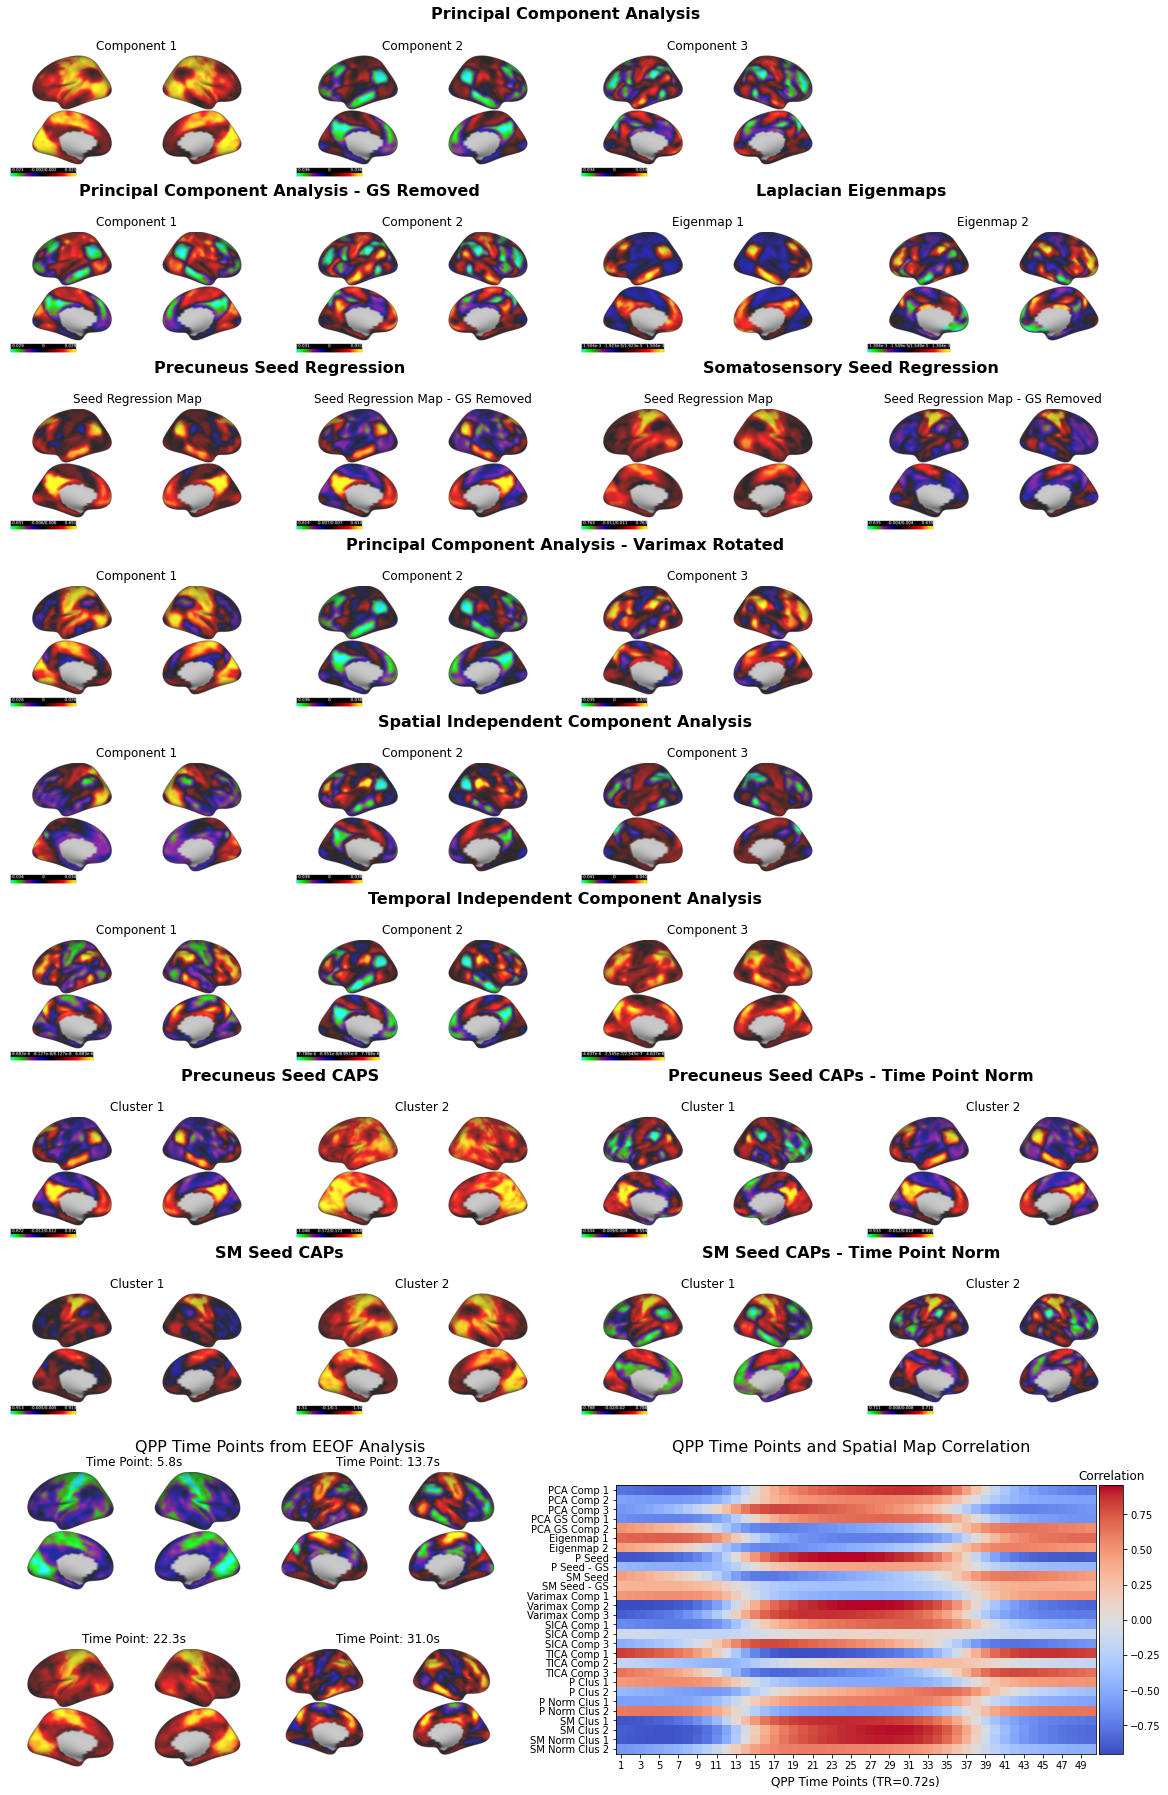

In [20]:
cifti_fps = (
    'demo_files/pca_rest.dtseries.nii', 'demo_files/pca_tmode_rest.dtseries.nii', 
    'demo_files/diffusion_embedding.dtseries.nii', 'demo_files/pca_rest_varimax.dtseries.nii',
    'demo_files/fc_map_precuneus.dtseries.nii', 'demo_files/fc_map_gs_precuneus.dtseries.nii',
    'demo_files/fc_map_sm.dtseries.nii', 'demo_files/fc_map_gs_sm.dtseries.nii', 
    'demo_files/s_ica.dtseries.nii', 'demo_files/t_ica.dtseries.nii', 
    'demo_files/caps_precuneus_c2.dtseries.nii', 'demo_files/caps_precuneus_norm_c2.dtseries.nii',
    'demo_files/caps_sm_c2.dtseries.nii', 'demo_files/caps_sm_norm_c2.dtseries.nii'
)
fps = (
    ['demo_files/pca_rest_comp0.png', 'demo_files/pca_rest_comp1.png', 'demo_files/pca_rest_comp2.png'],
    [['demo_files/pca_rest_gs_comp0.png', 'demo_files/pca_rest_gs_comp1.png'],
     ['demo_files/diffusion_emb_comp0.png', 'demo_files/diffusion_emb_comp1.png']], 
    [['demo_files/fc_map_precuneus.png', 'demo_files/fc_map_precuneus_gs.png'],
     ['demo_files/fc_map_sm.png', 'demo_files/fc_map_sm_gs.png']], 
    ['demo_files/pca_rest_varimax_comp0.png', 'demo_files/pca_rest_varimax_comp1.png', 'demo_files/pca_rest_varimax_comp2.png'], 
    ['demo_files/spatial_ica_comp0.png', 'demo_files/spatial_ica_comp1.png', 'demo_files/spatial_ica_comp2.png'], 
    ['demo_files/temporal_ica_comp0.png', 'demo_files/temporal_ica_comp1.png', 'demo_files/temporal_ica_comp2.png'], 
    [['demo_files/caps_precuneus_cluster0_c2.png', 'demo_files/caps_precuneus_cluster1_c2.png'],
     ['demo_files/caps_precuneus_norm_cluster0_c2.png', 'demo_files/caps_precuneus_norm_cluster1_c2.png']],
    [['demo_files/caps_sm_cluster0_c2.png', 'demo_files/caps_sm_cluster1_c2.png'],
     ['demo_files/caps_sm_norm_cluster0_c2.png', 'demo_files/caps_sm_norm_cluster1_c2.png']]
)
labels = (
    ['Component 1', 'Component 2', 'Component 3'],
    [['Component 1', 'Component 2'], ['Eigenmap 1', 'Eigenmap 2']], 
    [['Seed Regression Map', 'Seed Regression Map - GS Removed'], ['Seed Regression Map', 'Seed Regression Map - GS Removed']],
    ['Component 1', 'Component 2', 'Component 3'], 
    ['Component 1', 'Component 2', 'Component 3'], 
    ['Component 1', 'Component 2', 'Component 3'],
    [['Cluster 1', 'Cluster 2'], ['Cluster 1', 'Cluster 2']],
    [['Cluster 1', 'Cluster 2'], ['Cluster 1', 'Cluster 2']]
)
labels_short = (
    'PCA Comp 1', 'PCA Comp 2', 'PCA Comp 3', 'PCA GS Comp 1', 'PCA GS Comp 2',
    'Eigenmap 1', 'Eigenmap 2', 'P Seed', 'P Seed - GS', 'SM Seed', 'SM Seed - GS',
    'Varimax Comp 1', 'Varimax Comp 2', 'Varimax Comp 3', 'SICA Comp 1', 'SICA Comp 2', 
    'SICA Comp 3', 'TICA Comp 1', 'TICA Comp 2', 'TICA Comp 3', 'P Clus 1', 'P Clus 2', 
    'P Norm Clus 1', 'P Norm Clus 2', 'SM Clus 1', 'SM Clus 2', 'SM Norm Clus 1', 
    'SM Norm Clus 2'
)
section_labels = (
    'Principal Component Analysis', 
    ['Principal Component Analysis - GS Removed', 'Laplacian Eigenmaps'],
    ['Precuneus Seed Regression', 'Somatosensory Seed Regression'], 
    'Principal Component Analysis - Varimax Rotated', 
    'Spatial Independent Component Analysis', 
    'Temporal Independent Component Analysis', 
    ['Precuneus Seed CAPS', 'Precuneus Seed CAPs - Time Point Norm'], 
    ['SM Seed CAPs', 'SM Seed CAPs - Time Point Norm']
)

cifti_maps_all = []
for fp in cifti_fps:
    _, cifti_maps, n_time = pull_cifti_data(load_cifti(fp))
    if any([label in fp for label in ['pca_rest', 'ica']]):
        cifti_maps_all.append(cifti_maps[:3, :])
    else:
        cifti_maps_all.append(cifti_maps[:2, :])
cifti_maps_all = np.vstack(cifti_maps_all)
zero_mask = np.std(cifti_maps_all, axis=0) > 0
zero_mask_indx = np.where(zero_mask)[0]
cifti_maps_all = cifti_maps_all[:, zero_mask].copy()


fig = plt.figure(figsize=(20,32), constrained_layout=False)
gspec = fig.add_gridspec(10, 4, wspace=0.1)


for row, sec_labels in enumerate(section_labels, start=0):
    if isinstance(sec_labels, list):
        big_ax00 = fig.add_subplot(gspec[row,:2])
        big_ax01 = fig.add_subplot(gspec[row,2:])
        big_ax00.set_title(f"{sec_labels[0]}\n", fontsize=16, fontweight='bold')
        big_ax01.set_title(f"{sec_labels[1]}\n", fontsize=16, fontweight='bold')
        # Turn off axis lines and ticks of the big subplot 
        big_ax00.axis('off'); big_ax01.axis('off')
    else:
        big_ax = fig.add_subplot(gspec[row,:])
        big_ax.set_title(f"{sec_labels}\n", fontsize=16, fontweight='bold')
        # Turn off axis lines and ticks of the big subplot 
        big_ax.axis('off')

indx = 0
for fp_sec, label_sec in zip(fps, labels):
    if all(isinstance(i, list) for i in label_sec):
        label_flat = [label for label_two in label_sec for label in label_two]
        fp_flat = [fp for fp_two in fp_sec for fp in fp_two]
        for j in range(4):
            ax00 = fig.add_subplot(gspec[indx,j])
            img = mpimg.imread(fp_flat[j])
            ax00.set_title(label_flat[j])
            ax00.imshow(img)
            ax00.axis('off')
    else:
        for j in range(3):
            ax00 = fig.add_subplot(gspec[indx,j])
            if j <= (len(fp_sec) - 1):
                img = mpimg.imread(fp_sec[j])
                ax00.set_title(label_sec[j])
                ax00.imshow(img)
            ax00.axis('off')
    indx += 1

_, mssa_weights, _ = pull_cifti_data(load_cifti('demo_files/mssa_comp0_w50.dtseries.nii'))
cifti_maps_n = cifti_maps_all.shape[0]
mssa_weights = mssa_weights[:, zero_mask]
corr_mat = np.corrcoef(cifti_maps_all, mssa_weights)


sub_gs = gridspec.GridSpecFromSubplotSpec(2,4, subplot_spec=gspec[8:, :], wspace=0.5)
sub_gs00 = gridspec.GridSpecFromSubplotSpec(1,1, subplot_spec=sub_gs[:, 2:])
ax02 = fig.add_subplot(sub_gs00[:,:])
img = plt.imshow(corr_mat[:cifti_maps_n, cifti_maps_n:], cmap='coolwarm')
divider = make_axes_locatable(ax02)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(img, cax=cax)
cbar.ax.set_title("Correlation", fontsize=12)
ax02.set_yticks(list(range(cifti_maps_n)))
ax02.set_yticklabels(labels_short)
ax02.set_xticks(np.arange(mssa_weights.shape[0]))
ax02.xaxis.set_major_locator(plt.MultipleLocator(2))
ax02.set_xticklabels(['0'] + [str(i+1) for i in np.arange(0, mssa_weights.shape[0],2)])
ax02.set_xlabel('QPP Time Points (TR=0.72s)', fontsize=12)


big_ax1 = fig.add_subplot(gspec[8:,:2])
big_ax1.set_title('QPP Time Points from EEOF Analysis', fontsize=16)
big_ax1.axis('off')

big_ax2 = fig.add_subplot(gspec[8:,2:])
big_ax2.set_title('QPP Time Points and Spatial Map Correlation', fontsize=16)
big_ax2.axis('off')

img_indx = [7, 18, 30, 42]
sub_gs01 = gridspec.GridSpecFromSubplotSpec(2,2, subplot_spec=sub_gs[:, :2], wspace=0)
indx = 0
for i in range(2):
    for j in range(2):
        ax03 = fig.add_subplot(sub_gs01[i,j])
        img = mpimg.imread(f'demo_files/mssa_comp0_w50_t{img_indx[indx]+1}.png')
        ax03.set_title(f'Time Point: {round((img_indx[indx]+1)*tr,1)}s')
        ax03.imshow(img)
        ax03.axis('off') 
        indx+=1    

plt.show()

<font size='4'> The spatial maps returned by popular zero-lag correlation analyses exhibit striking similarity. The following general observations can be made (further elaborated on below):</font>
<ol>    
    <font size='4'>
    <li> Interestingly, the contrast of spatial weights within each spatial map exhibit a striking correspondence to the two 'ends' of the QPP: sensorimotor, lateral visual, and superior temporal gyrus vs. the DMN. As displayed in the bottom right correlation plot, all spatial maps returned from zero-lag analyses (excluding SICA Component 1) strongly resemble the spatial patterns of the QPP at select time points. In other words, these static spatial maps resemble 'snapshots' of the QPP's spatiotemporal pattern. We show in <b>Appendix A</b> that the spatial similarities between zero-lag maps are arranged along two axes in a 2-dimensional similarity space, corresponding to the global (time points 5 and 30) and bipolar phases of the QPP (time points 16 and 30).</li>
    <li>All- or close-to-all-positive and -negative maps appear across several analyses, particularly those without global signal regression, or time-point normalization or demeaning (i.e. frame-by-frame intensity normalization).</li>
    <li>A bipolar positive and negative pattern is returned by almost all analyses. This bipolar pattern has different names dependening on the analysis approach used to derive it - the task-positive/task-negative (TP/TN) pattern or network, or the primary functional connectivity gradient. </li>
    <li>A multipolar pattern of positive and negative weights similar in spatial distribution to the bipolar positive and negative pattern. See for example, 'Component 3' from the PCA, and 'Component 2' from the Laplacian Eigenmaps.</li>
    <li>Despite the striking similarity of spatial maps returned by these analyses, the results of each analysis are often given different physical interpretations: global signal, task-positive/task-negative network, connectivity gradients, discrete point processes, etc.</li>
    <li>Some of the results of these analyses depend on the number of components/cluster estimated. For example, both ICA and PCA-rotation method outputs will change depending on the number of components estimated. The more components, the finer the distinctions. Given we are interested in coarse, global patterns such as the QPP, we keep the number of components estimated to a minimum. Non-rotated eigendecomposition analyses, such as PCA and Laplacian Eigenmaps, do not have a dependence on component number. Nor is this obviously the case with seed-based correlation analyses.</li>
    <li>As with the spatial maps, the time courses of the spatial maps from zero-lag analyses reveal strong similarities. In fact, all of the component time courses exhibit strong correlations with at least one of the component time courses from another zero-lag analysis (<b>Appendix B</b>).</li>
       
</font>
</ol>


# <b>3. Spatial and Temporal Properties of Zero-Lag Analysis</b>

<font size='4'>The spatial maps produced from zero-lag analysis strongly resemble snapshots of the QPP pattern. However, these results do not demonstrate <i>why</i> or <i>how</i> zero-lag analysis of spatiotemporal propagation pattern produces these specific spatial patterns. In this section, we describe the relationship between QPP dynamics and the spatial patterns produced by zero-lag analysis.</font>

## 3.1 Eigendecomposition of Resting-State BOLD Correlations

### 3.1.1 Principal Component Analysis of Resting-State BOLD correlations

<font size='4'><b>Eigendecomposition techniques</b> are well-suited for extracting the sorts of global patterns exhibited by the QPP. In the case of a symmetric matrix, eigendecomposition techniques decompose the matrix into an orthogonal set of basis vectors, known as eigenvectors, and associated scaling values, known as eigenvalues. Eigendecomposition applied to a covariance/correlation matrix is known as principal component analysis (PCA). The top N eigenvectors (and associated eigenvalues) or principal components of a covariance matrix represent the top N dimensions of variability in the data. This property of PCA makes it a popular tool for dimension reduction. </font>
    
    
<font size='4'> Eigendecomposition methods have enjoyed a recent resurgence in usage due to the popularity of 'functional connecitivty gradients' in resting-state fMRI analysis. Two popular approaches in this domain include Laplacian Eigenmaps and diffusion map embedding. Both methods employ an eigendecomposition of a kernel/similarity matrix with the potential to capture non-linear structure between BOLD time series. Both these methods are closely related to kernel PCA - PCA extended to arbitrary kernel/similarity functions (beyond just correlation/covariance). Laplacian Eigenmap embedding represents a special case of Kernel PCA, and diffusion map embedding has close relationships with kernel PCA as well. As can be observed from <b>Section 2.1</b>, we found that Laplacian Eigenmap embedding returned similar results to PCA when applied to the same whole-brain BOLD time series. This is similar to the findings of Vos de Wael et al. (2020), where they also found that diffusion map embedding returned equivalent results to PCA. We discuss these findings in <b>Appendix C</b>.</font> 

<font size='4'> For reference, we again present the spatial weights for the first three principal components below:

In [121]:
np.sum(exp_var[:3])

0.3332290365518651

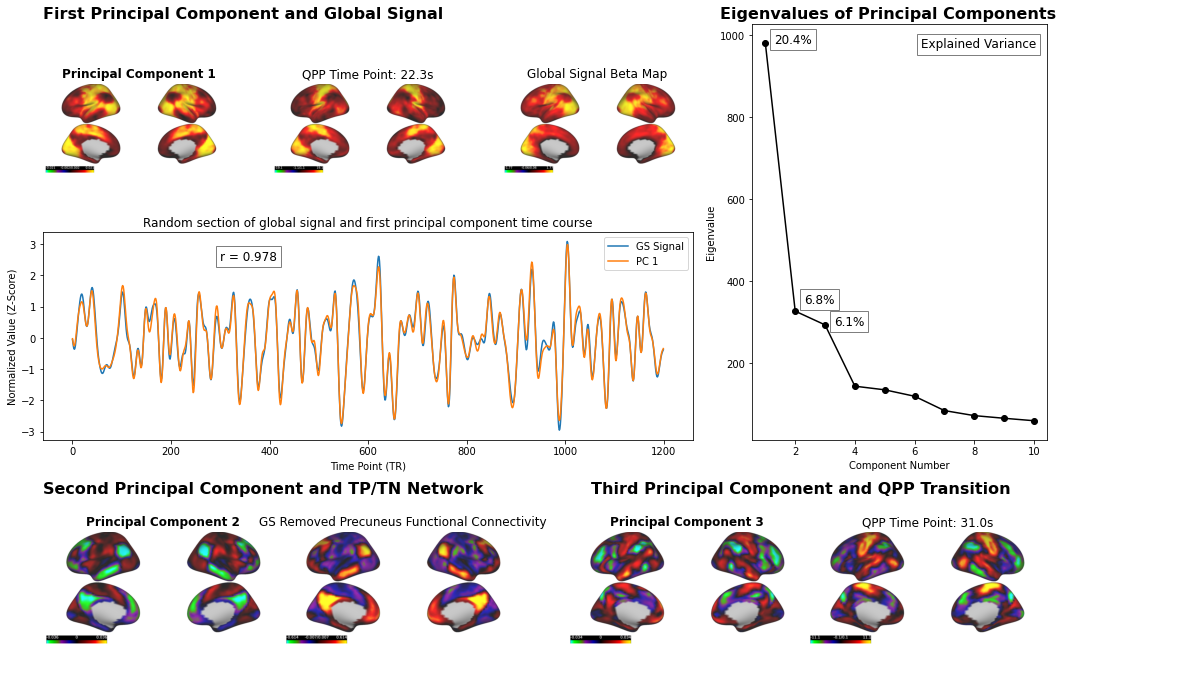

In [119]:
pca_ts = pickle.load(open('demo_files/pca_ts.pkl', 'rb'))
gs_signal = pickle.load(open('demo_files/gs_results.pkl', 'rb'))
comp0_ts = pca_ts[:, 0]
corr_coef = np.corrcoef(comp0_ts.T, gs_signal.T)[0,1]

n_vertices = 4801
eigs = [np.var(pca_ts[:,i]) for i in range(pca_ts.shape[1])]
exp_var = [eig/n_vertices for eig in eigs]

fig = plt.figure(figsize=(18,12), constrained_layout=False)
gspec = fig.add_gridspec(2,1, wspace=0.05, height_ratios=[0.7, 0.3])

sub_big_ax = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gspec[0,:])
big_ax = fig.add_subplot(sub_big_ax[0]); big_ax.axis('off')
big_ax.set_title('First Principal Component and Global Signal', fontsize=16, fontweight='bold', loc='left')
big_ax = fig.add_subplot(sub_big_ax[1]); big_ax.axis('off')
big_ax.set_title('Eigenvalues of Principal Components', fontsize=16, fontweight='bold', loc='left')
pos1 = big_ax.get_position() # get the original position 
pos2 = [pos1.x0 + 0.1, pos1.y0,  pos1.width, pos1.height] 
big_ax.set_position(pos2) # set a new position

sub_big_ax = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gspec[1,:])
big_ax = fig.add_subplot(sub_big_ax[0]); big_ax.axis('off')
big_ax.set_title('Second Principal Component and TP/TN Network', fontsize=16, fontweight='bold', loc='left')
big_ax = fig.add_subplot(sub_big_ax[1]); big_ax.axis('off')
big_ax.set_title('Third Principal Component and QPP Transition', fontsize=16, fontweight='bold', loc='left')

   
sub_gs0 = gridspec.GridSpecFromSubplotSpec(1,3, subplot_spec=gspec[0], wspace=0.2)
sub_gs0_0 = gridspec.GridSpecFromSubplotSpec(2,3, subplot_spec=sub_gs0[:2], hspace=0)
sub_gs0_1 = gridspec.GridSpecFromSubplotSpec(1,1, subplot_spec=sub_gs0[2])
ax = fig.add_subplot(sub_gs0_0[0,0])
img = mpimg.imread('demo_files/pca_rest_comp0.png')
ax.set_title('Principal Component 1', fontweight='bold')
ax.imshow(img)
ax.axis('off')

ax = fig.add_subplot(sub_gs0_0[0,1])
img = mpimg.imread('demo_files/mssa_comp0_w50_t31_cmap.png')
ax.set_title(f'QPP Time Point: {round(31*tr, 1)}s')
ax.imshow(img)
ax.axis('off')

ax = fig.add_subplot(sub_gs0_0[0,2])
img = mpimg.imread('demo_files/gs_map.png')
ax.set_title('Global Signal Beta Map')
ax.imshow(img)
ax.axis('off')

ax = fig.add_subplot(sub_gs0_0[1,:])
ax.plot(zscore(gs_signal[1200:2400]), label='GS Signal')
ax.plot(zscore(comp0_ts[1200:2400]), label='PC 1')
ax.set_title('Random section of global signal and first principal component time course', fontsize=12)
ax.set_xlabel('Time Point (TR)')
ax.set_ylabel('Normalized Value (Z-Score)')
ax.text(300,2.5, r'r = {}'.format(np.round(corr_coef,3)), fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
ax.legend()

ax = fig.add_subplot(sub_gs0_1[0])
ax.plot(list(range(1,11)), eigs, '-o', color='black')
ax.set_xlabel('Component Number')
ax.set_ylabel('Eigenvalue')
x_adj = 0.3
for i in range(3):
    if i == 1:
        y_adj=20
    else:
        y_adj=0
    ax.text((i+1)+x_adj,eigs[i]+y_adj, 
            r'{}%'.format(np.round(exp_var[i]*100,1)), 
            fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
ax.text(6.2, 970, 'Explained Variance', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

sub_gs1 = gridspec.GridSpecFromSubplotSpec(1,4, subplot_spec=gspec[1], wspace=0.2)
sub_gs1_0 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=sub_gs1[:2], wspace=0)
ax = fig.add_subplot(sub_gs1_0[0,0])
img = mpimg.imread('demo_files/pca_rest_comp1.png')
ax.set_title('Principal Component 2', fontweight='bold')
ax.imshow(img)
ax.axis('off')

ax = fig.add_subplot(sub_gs1_0[0,1])
img = mpimg.imread('demo_files/fc_map_precuneus_gs.png')
ax.set_title('GS Removed Precuneus Functional Connectivity')
ax.imshow(img)
ax.axis('off')

sub_gs1_1 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=sub_gs1[2:], wspace=0)
ax = fig.add_subplot(sub_gs1_1[0,0])
img = mpimg.imread('demo_files/pca_rest_comp2.png')
ax.set_title('Principal Component 3', fontweight='bold')
ax.imshow(img)
ax.axis('off')

ax = fig.add_subplot(sub_gs1_1[0,1])
img = mpimg.imread('demo_files/mssa_comp0_w50_t19_cmap.png')
ax.set_title(f'QPP Time Point: {round(43*tr,1)}s')
ax.imshow(img)
ax.axis('off')

plt.show()

<font size='4'> As discussed above, the spatial pattern of weights in all three principal components contrast the early and late regions of the QPP in different ways. Observations of the distribution of weights within each map reveals the following trend: the first principal component is unipolar (i.e. one peak of positive weight values), the second principal component is bipolar, and the third principal component is multipolar. Together, these components account for 33% of the total variance in cortex-wide BOLD signals. The first principal component accounts for a substantial majority of this number at 20% of the total variance. </font>

<font size='4'>The first principal component spatial pattern corresponds closely to the globally positive propagation event of the QPP. Further, the first principal component corresponds precisely to what has been called the 'global signal.' Despite debate over its physical interpretation, the global signal is often defined statistically as the arithmetic mean of whole-brain cortical (sometimes including non-cortical) BOLD time series. The relationship between the global signal and first principal component has been previously noted by Carbonell et al. (2013 - Brain Connectivity). As illustrated in the above figure, the global signal time series and first principal component time series are statistically indistinguishable (*r=0.978*). Both the global signal (derived by regression of BOLD signal on the mean signal) and first principal component spatial patterns exhibit strong positive weights in the superior parietal, sensorimotor and visual cortices (outside of the primary visual). The global signal beta map has slightly less positive patterns along the medial sensorimotor cortex compared to the first principal component.</font>

<font size='4'> The second principal component corresponds to the task-positive/task-negative (TP/TN) pattern (flipped sign) first observed by Fox et al. (2005; PNAS). This contrasting pattern is perhaps the most studied and observed phenomonen in resting-state fMRI. As shown by Fox et al. (2005), the TP/TN pattern can be derived by seed-based regression or correlation with a seed placed in a region of the Default Mode Network (DMN). Further, the anti-correlation pattern between the TP and TN is only observed following global signal regression. In the functional connectivity gradient literature, this pattern is typically derived through a manifold learning algorithm and referred to as the primary functional connectivity gradient.   

<font size='4'> As can observed from the findings in <b>Sec 3.1</b> and <b>Appendix A</b>, the spatial pattern of component 3 corresponds closely to the transition period between the two global positive and negative propagation patterns. In this period, BOLD activity in beginning regions of the QPP (sensorimotor, superior temporal and lateral visual) is moving more positive/negative, but still has not reached its peak/trough (i.e. peak/trough amplitude). On the other hand, BOLD activity in the end regions of the QPP is moving less negative/positive, away from its peak/trough amplitude. 
    
<font size='4'> All of the zero-lag analysis spatial maps displayed above in <b>Sec 3.1</b> closely resemble one of these three principal components. For example, principal component 1 resembles the  seed-based regression maps (without global signal regression) and the cluster 2 centroid map from the somatosensory-seeded CAP analysis. Principal component 2 resembles component 1 from Spatial ICA and the global-signal regressed seed-based Precuneus regression map. Principal component 3 resembles component 3 from Spatial ICA and component 1 from temporal ICA (with a sign flip). What is still yet to be made clear: how do the specific spatial patterns of each component (and spatial maps closely resembling those components) relate to the spatiotemporal dynamics of the QPP? Further, are these principal components descriptions of the same, or different dynamics in the QPP? We address these questions in the following section.</font> 

### 3.1.2 The Relationship Between Zero-Lag Eigendecomposition and the QPP

<font size='4'> To relate the first three principal components to the dynamics of the QPP, we projected the time points of the QPP on to the three dimensional space spanned by the first three components. The time progression of the QPP is displayed as a cyclical color map, where different time points are colored according to a continuous color scale.  For reference, we plotted a random selection of time points (N=5000) from the original resting-state BOLD data projected in to the same three dimensional space. These projected time points from the resting-state BOLD data are referred to as 'principal component scores'. We display the three dimensional principal component space at the top, followed by each pair of the principal components in a 2-dimensional space (1-2, 1-3, and 2-3).</font>

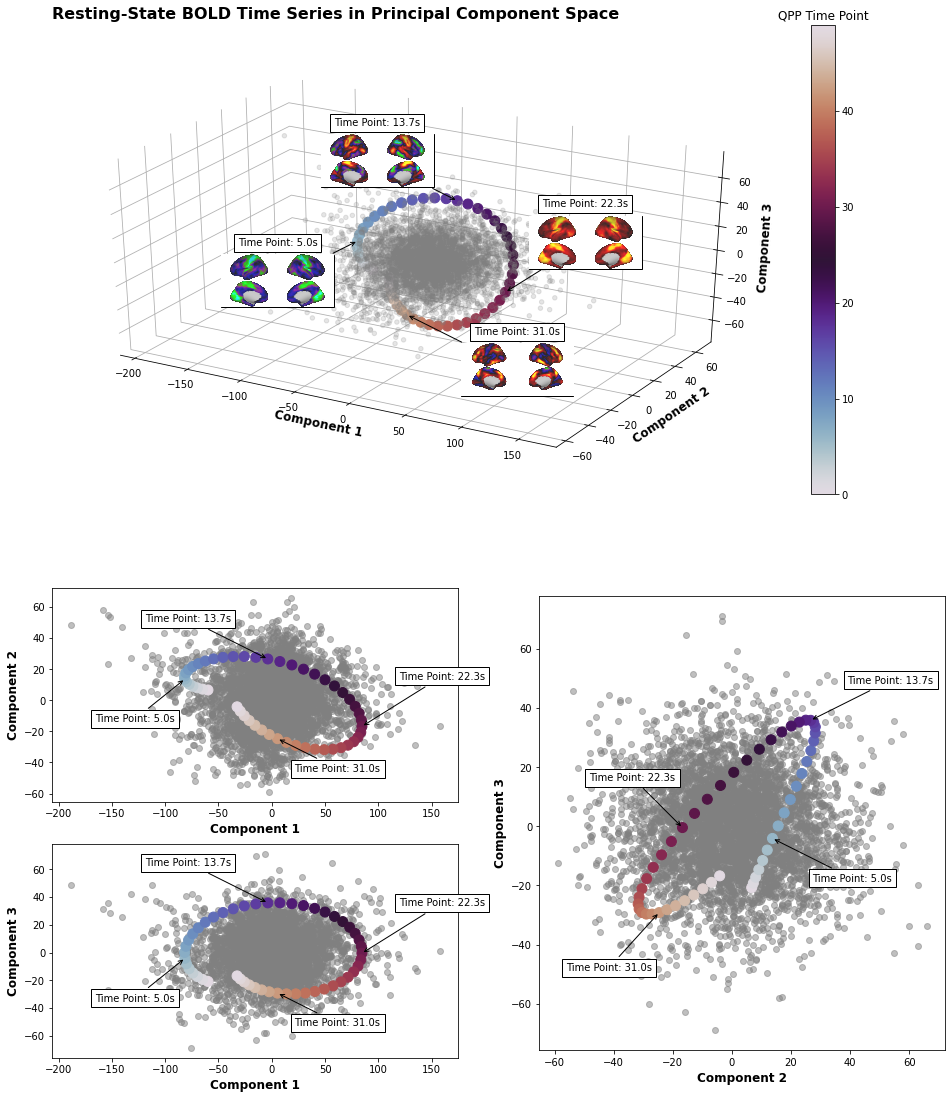

In [91]:
def short_proj():
    return np.dot(Axes3D.get_proj(ax00), scale)

pca_ts = pickle.load(open('demo_files/pca_ts.pkl', 'rb'))
V = pickle.load(open('demo_files/pca_eigen.pkl', 'rb')) # X = USV
rand_indx = rand.permutation(pca_ts.shape[0])[:5000]
comp_scores = pca_ts[rand_indx, :]

fig = plt.figure(figsize=(16,19), constrained_layout=False)
gspec = fig.add_gridspec(1,1, hspace=0)

g_sub0 = gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gspec[0])

big_ax = fig.add_subplot(g_sub0[0]); big_ax.axis('off')
big_ax.set_title('Resting-State BOLD Time Series in Principal Component Space', fontsize=16, fontweight='bold', loc='left')

x_scale=1.5
y_scale=1
z_scale=1
g_sub0_0 = gridspec.GridSpecFromSubplotSpec(1,1, subplot_spec=g_sub0[0])
ax00 = fig.add_subplot(g_sub0_0[0], projection='3d')
scale = axis3d_scaler(x_scale,y_scale,z_scale)
ax00.get_proj=short_proj
ax00.scatter(comp_scores[:,0], comp_scores[:,1], comp_scores[:,2], c='gray', alpha=0.2)
mssa_weights_proj = zscore(mssa_weights) @ V.T
time_indx = np.arange(50)
sp = ax00.scatter(mssa_weights_proj[:,0], mssa_weights_proj[:,1], mssa_weights_proj[:,2], 
                  c=time_indx, cmap=plt.cm.twilight, s=100, alpha=1)
cbar = plt.colorbar(sp, ax=ax00)
cbar.ax.set_title('QPP Time Point')
ax00.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax00.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax00.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax00.set_xlabel('Component 1', fontsize=12, fontweight='bold')
ax00.set_ylabel('Component 2', fontsize=12, fontweight='bold')
ax00.set_zlabel('Component 3', fontsize=12, fontweight='bold')
ax00.dist = 8

ax01 = fig.add_subplot(g_sub0_0[0], frameon=False)
ax01.axis("off")
ax01.axis([0,1,0,1])
img_indx = [6, 18, 30, 42] 
x_shift = [-80, -80, 80, 110]
y_shift = [-40, 40, 50, -55]
for indx, offset_x, offset_y in zip(img_indx, x_shift, y_shift):
    img = mpimg.imread(f'demo_files/mssa_comp0_w50_t{indx+1}.png')
    label = f'Time Point: {round((indx+1)*tr,1)}s'
    coords = (mssa_weights_proj[indx, 0], mssa_weights_proj[indx, 1], mssa_weights_proj[indx, 2])
    x,y = proj_3d(coords, ax00, ax01)
    image_3d(ax01,img,label, [x,y],offset_x,offset_y,38, 0.05)
    text_offset_x = x - 0.01/x
    text_offset_y = y + 0.01/y
    

x_shift = [-50, -80, 80, 60]
y_shift = [-40, 40, 50, -30]
g_sub0_1 = gridspec.GridSpecFromSubplotSpec(2,2, subplot_spec=g_sub0[1])
ax1 = fig.add_subplot(g_sub0_1[0,0])
ax1.scatter(comp_scores[:,0], comp_scores[:,1], c='gray', alpha=0.5)
ax1.set_xlabel('Component 1', fontsize=12, fontweight='bold')
ax1.set_ylabel('Component 2', fontsize=12, fontweight='bold')
im = ax1.scatter(mssa_weights_proj[:,0], mssa_weights_proj[:,1], c=time_indx, cmap=plt.cm.twilight, s=100)
# ax1.set_aspect(0.8)
for indx, offset_x, offset_y in zip(img_indx, x_shift, y_shift):
    offsetbox = TextArea(f'Time Point: {round((indx+1)*tr,1)}s', minimumdescent=False)
    xy = (mssa_weights_proj[indx,0], mssa_weights_proj[indx,1])
    ab = AnnotationBbox(offsetbox, xy,
                        xybox=(offset_x, offset_y),
                        xycoords='data',
                        boxcoords=("offset points"), 
                        arrowprops=dict(arrowstyle="->"))
    ax1.add_artist(ab)

ax2 = fig.add_subplot(g_sub0_1[1,0])
ax2.scatter(comp_scores[:,0], comp_scores[:,2], c='gray', alpha=0.5)
ax2.set_xlabel('Component 1', fontsize=12, fontweight='bold')
ax2.set_ylabel('Component 3', fontsize=12, fontweight='bold')
im = ax2.scatter(mssa_weights_proj[:,0], mssa_weights_proj[:,2], c=time_indx, cmap=plt.cm.twilight, s=100)
# ax2.set_aspect(0.8)
for indx, offset_x, offset_y in zip(img_indx, x_shift, y_shift):
    offsetbox = TextArea(f'Time Point: {round((indx+1)*tr,1)}s', minimumdescent=False)
    xy = (mssa_weights_proj[indx,0], mssa_weights_proj[indx,2])
    ab = AnnotationBbox(offsetbox, xy,
                        xybox=(offset_x, offset_y),
                        xycoords='data',
                        boxcoords=("offset points"), 
                        arrowprops=dict(arrowstyle="->"))
    ax2.add_artist(ab)

ax3 = fig.add_subplot(g_sub0_1[:,1])
ax3.scatter(comp_scores[:,1], comp_scores[:,2], c='gray', alpha=0.5)
ax3.set_xlabel('Component 2', fontsize=12, fontweight='bold')
ax3.set_ylabel('Component 3', fontsize=12, fontweight='bold')
im = ax3.scatter(mssa_weights_proj[:,1], mssa_weights_proj[:,2], c=time_indx, cmap=plt.cm.twilight, s=100)
ax3.set_aspect(1)

x_shift = [80, 80, -50, -50]
y_shift = [-40, 40, 50, -55]
for indx, offset_x, offset_y in zip(img_indx, x_shift, y_shift):
    offsetbox = TextArea(f'Time Point: {round((indx+1)*tr,1)}s', minimumdescent=False)
    xy = (mssa_weights_proj[indx,1], mssa_weights_proj[indx,2])
    ab = AnnotationBbox(offsetbox, xy,
                        xybox=(offset_x, offset_y),
                        xycoords='data',
                        boxcoords=("offset points"), 
                        arrowprops=dict(arrowstyle="->"))
    ax3.add_artist(ab)

plt.show()

<font size='4'>The time points of the QPP are represented in the 3-dimensional principal component space as an elongated oval that roughly encloses the time points of the resting-state BOLD time series (plotted in gray). The first principal component is the axis along which BOLD time series vary the greatest. Thus, the cloud of time-points is stretched greatest along the X-axis, corresponding to the first principal component. The QPP dynamics are similarly stretched greatest along the first principal component axis, creating a streched oval appearance. The 2-dimensional principal component plots make this 'streching' along the first principal component more easily observed. Consistent with the globally positive spatial weights of the first principal component, the globally positive (6 sec) and negative (22 sec) BOLD activation time points of the QPP are located on the two ends of the first principal component axis. Transition points in the QPP occur around 14 and 31 seconds, corresponding to peak positive amplitudes in the beginning and end regions of the QPP, respectively. These contrasting transition points are maximally separated along the third principal component, as can be observed from the 1-3 and 2-3 component 2-dimensional plots. Thus, the dynamics of the global propagation and transition period are well separated along the first and third principal components.

<font size='4'>The global propagation and transition periods of the QPP seem to both vary along the second principal component axis. The globally positive (6 sec) and negative (22 sec) patterns of the QPP vary along both the first and slightly along the second principal component, as can be observed from the 1-2 component 2-dimensional map. The oval formed by the QPP is oriented at negative angle in the first and second principal component space. In other words, the second principal component is capturing some of the same dynamics in the QPP represented by the first principal component. This is the not the case for the third principal component, where the globally positive and negative periods of the QPP are located along the same point of its axis. The transition period also seems to vary along the second principal component, as observed in the 2-3 component 2-dimensional map. In this case too, the oval formed by the QPP is oriented at an angle in the 2-dimensional space. In fact, the transition periods of the QPP are located at the ends of both the second and third principal component axes. Thus, the second principal component seems to capture much of the same dynamics in the QPP represented by the third principal component. </font>

<font size='4'> A central question is whether these components correspond to physically distinct modes of BOLD dynamics. Its helpful to consider the properties of the second principal component: it is the second most dimension of variability spatially orthogonal to, and temporally uncorrelated with, the first principal component. The third principal components is the third most dimension of variability spatially orthogonal to, and temporally uncorrelated with, the second and first principal component, and so on. Eigenvector decomposition of any symmetric vertex-by-vertex similarity matrix will produce an orthogonal set of spatial eigenvectors. Thus, the same constraint applies to most manifold learning algorithms popular in the functional connectivity gradient literature, such as Laplacian Eigenmaps and Diffusion Embedding. The orthogonality constraints of eigenvector decomposition may sometimes have undesirable consequences for the physical interpretability of the resulting components. In fact, it has been known for some time (Horel, 1981; Richman, 1986) that the orthogonality constraint of PCA (and eigenvector decomposition more generally) can yield predictable patterns in the components following the first principal component. For example, if the weights of the first principal component are unipolar (i.e. all positive or all negative), the second component will generally be bipolar with its zero value passing through the highest value point in the first component; this will generally be followed a more complex, multipolar pattern of weights in third component with maxima near zero-points of the first and second components. In other words, while the first principal component is not affected by this orthogonality constraint, the subsequent principal components have predictable patterns related to the first component that arise due to the orthogonality constraints between them. This is exactly what is observed between the first three principal components of resting-state BOLD signals: following the unipolar all-positive first principal component, the second principal component is bipolar, with weight values near zero in the somatosensory cortex, the area of maximum weight values in the first component. In addition, the third principal component is a more complex, multipolar pattern of spatial weights compared to the second principal component. In fact, it is possible to produce the same overall progression of spatial patterns (unipolar, bipolar and multipolar) when principal components are applied to an arbitrary global BOLD propagation simulation (<b>Appendix D</b>).</font>

<font size='4'> To be clear, the above observations do not imply that the principal components following the first component are artifactual. The principal components are still data-driven representations of the covariance structure of resting-state BOLD signals, subject to the orthogonality constraints of PCA. However, these observations do suggest that the principal components should not be interpreted in isolation. In our case, all three principal components capture facets of a single spatiotemporally extended pattern, the QPP. In some cases, distinct periods of the QPP are separated into two components: the global propagation and transition periods of the QPP are clearly separated along the first and third principal component axes. In other cases, there seems to be an indication of mixing of the same period across two components: the transition period varies along both the second and third principal component axes, and the global propagation period varies along both the first and second principal component axes. The potential mixing is also observed in the spatial weights between the three principal components. The Pearson correlation coefficient between the spatial weights of the first and second principal component: <i>r=0.7</i>. The Pearson correlation coefficient between the spatial weights of the second and third principal component: <i>r=0.2</i>. This observation may seem to contradict the spatial orthogonality constraint between principal components, but orthogonality and correlation are not identical concepts. Orthogonality is measured by the dot product between the two principal component spatial weights, while correlation/covariance is the normalized dot product of the principal component spatial weights with the <i>mean weight removed from each</i>. In other words, ignoring the amplitude differences between these principal components reveals similar spatial patterns between them. </font>
    
<font size='4'> Principal components are one low-dimensional latent space for representing the spatiotemporal dynamics of resting-state BOLD signals. Other popular zero-lag analyses based on zero-lag statistics include varimax rotation, temporal and spatial ICA. Varimax rotation and ICA amount to rotations of the original spatial loadings or principal component axes, respectively (<b>Appendix F</b>). As observed in <b>Sec 3.1</b>, all rotated component solutions return essentially similar results to the PCA solution. However, there are differences in the spatial and temporal properties of each rotated component solution, due to the unique constraints placed on each (<b>Appendix F</b>). Debate over which constraints are more biologically realistic fails to consider the observation that all of the components correspond to static snapshots of the dynamics of a single spatiotemporal pattern, the QPP. The analysis of zero-lag statistics is the fundamental limitation of both the original PCA and rotated solutions. Without the explicit modeling of time-lag structure, the dynamics of the temporally extended pattern of the QPP is inevitably distributed across multiple components. Importantly, the components of any of these solutions should not be interpreted in isolation; none correspond to physically independent dynamics of BOLD signals, but zero-lag descriptions of the temporaly extended QPP pattern. </font>

### 3.1.3 The Second Principal Component and its Relation to the Global Propagation Period of the QPP

<font size='4'> The temporal dynamics of the QPP vary along the first three principal component axes of the zero-lag PCA analysis. We noted above that the QPP dynamics isolated along the first and third principal components are also distributed along the second principal component. Further, the spatial patterns of the first and second principal components exhibit striking similarity, <i>r=0.7</i>. These findings point to a potential redundancy in the dynamics described by the first and second principal components. As shown in <b> Sec 3.1.1</b>, the time series of the first principal component is identical to the time series of the mean whole-brain amplitude, often labeled the 'global signal'. The spatial weights of the second principal component precisely match the task-positive/task-negative (TP/TN) network pattern often derived from seed-based functional connectivity analysis (Fox et al. 2005). The TP/TN network pattern has also been labeled the 'primary functional connectivity gradient' by Marguiles et al. (2016), where it was derived from a diffusion map embedding approach. </font>

<font size='4'> The global signal and TP/TN network pattern have been previously described as physically independent BOLD dynamics, arising from separable hemodynamic/neural mechanisms. We intend to show that these are actually descriptions of the same thing: the global propagation periods of the QPP. The second principal component (TP/TN network) is the second most dimension of variability orthogonal to the first principal comopnent. As noted above, the orthogonality constraint imposes the bipolar pattern of negative and positive weights observed in the second principal component. Further, this bipolar pattern is centered on the area of highest maximum weight values in the first principal components: the sensorimotor and superior temporal cortices. Previous studies have noted that global signal regression followed by seed-based functional connectivity returns the TP/TN network pattern (Fox et al. 2005; 2009). Without global signal regression, the spatial pattern of correlaton/regression coefficients returned by seed-based functional connectivity resembles the global spatial pattern of the first principal component weights. We observe the same behavior of PCA when it is applied to global-signal regressed or time-point centered data. The first principal compnent of these solutions are the TP/TN network pattern (<b>Sec 3.1</b> and <b>Appendix E</b>). This behavior of global signal regression has the same practical effects as the orthogonality constraint imposed by the PCA solution. In the case of PCA, the second principal component is the second most dimension of variability orthogonalized with respect to the first principal component. The first principal component is identical to the global signal. In the case of global signal regression, the first principal component/global signal is regressed from the data manually. In other words, global signal regression implicitly orthogonalizes resting-state BOLD signals with respect to the first principal component. Thus, seed based-functional connectivity analysis of global signal regressed data reliability returns the second principal component (TP/TN) spatial pattern.</font>

<font size='4'> The important question is whether by orthogonalizing with respect to the global signal, the residual time series are free of spatiotemporal dynamics corresponding to the the global propagation period of the QPP. We have already observed that the global propagation period covaries along both the first and second principal components, and that their spatial patterns are very similar. We can go further and demonstrate that the spatial pattern of the second principal component weights (TP/TN pattern) is entirely predictable from the dynamics of the global propagation period embodied in the first principal component. To illustrate this point, we utilize the observation that the real part of the complex principal components produced by CHEOF analysis (<b>Sec 2.1</b>) match the principal components returned from standard PCA of (non-complex) resting-state BOLD signals. The first three complex principal components provide information regarding the temporal dynamics of the first three standard principal components. Specifically, the phase representation of the first three complex principal components provides time-lag information in the form of phase offsets between vertices within each principal component. We previously noted in <b>Sec 2.1</b> that the time-lag phase map of the first principal component precisely matches the overall temporal dynamics of the QPP. In this section, we explore whether the time dynamics of the second principal component can be shown to be a redescription of the time dynamics of the first principal component. Below we plot the time delay phase maps for the first three complex principal components. Note, the real part of the first three complex component spatial weights precisely matches the spatial weights of the first three components from standard PCA.</font>
    

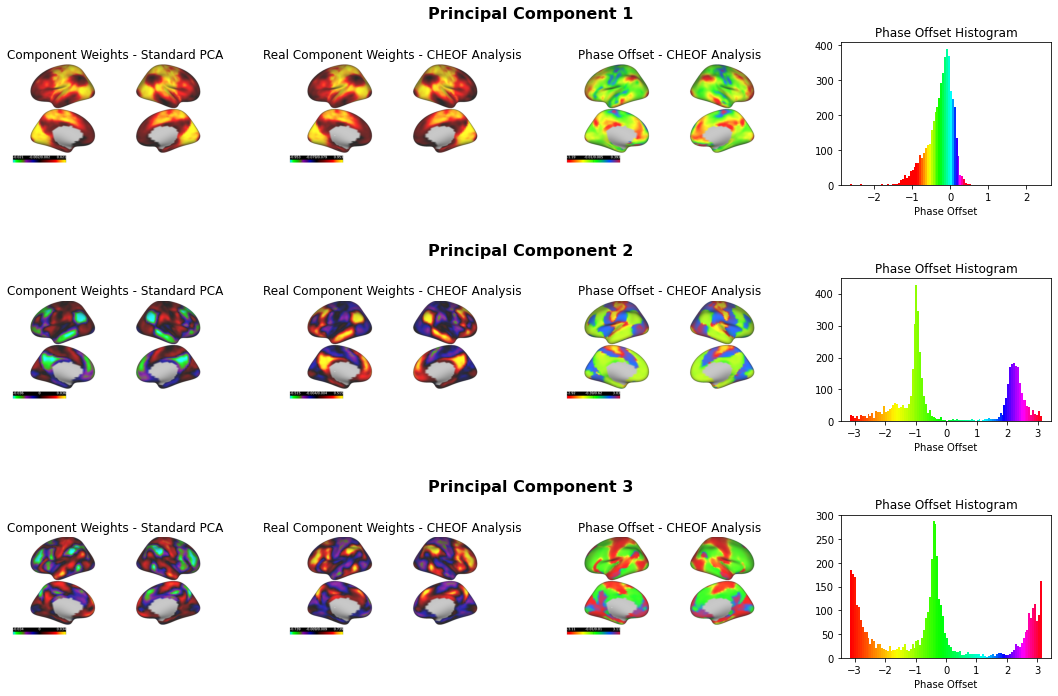

In [72]:
_, comp_phase, _ = pull_cifti_data(load_cifti('demo_files/pca_rest_complex_ang.dtseries.nii'))
comp_phase = comp_phase[:, zero_mask]

pc_fps = [['demo_files/pca_rest_comp0.png', 'demo_files/pca_rest_complex_comp0_real.png', 
           'demo_files/pca_rest_complex_comp0_ang_hsv.png'], 
          ['demo_files/pca_rest_comp1.png', 'demo_files/pca_rest_complex_comp1_real.png', 
           'demo_files/pca_rest_complex_comp1_ang_hsv.png'],
          ['demo_files/pca_rest_comp2.png', 'demo_files/pca_rest_complex_comp2_real.png', 
           'demo_files/pca_rest_complex_comp2_ang_hsv.png']]
labels = ['Component Weights - Standard PCA', 'Real Component Weights - CHEOF Analysis', 'Phase Offset - CHEOF Analysis']
section_labels = ['Principal Component 1', 'Principal Component 2', 'Principal Component 3']

fig, big_axes = plt.subplots(figsize=(15, 10), nrows=3, ncols=1, sharey=True) 

for row, (big_ax, section_labels) in enumerate(zip(big_axes, section_labels), start=1):
    big_ax.set_title(f"{section_labels}\n", fontsize=16, fontweight='bold')
    # Turn off axis lines and ticks of the big subplot 
    big_ax.axis('off')
    
cmap = plt.cm.get_cmap('hsv')
# Recenter hsv color map to match hsv brain color map from HCP Workbench - this was estimated visually
new_cmap = shiftedColorMap(cmap, midpoint=0.7)
cmap_lims = [[0.35,0.6], [0,1], [0,1]]

indx=0
for i in range(3):
    for j in range(4):
        indx+=1
        if j != 3:
            ax = fig.add_subplot(3,4,indx)
            img = mpimg.imread(pc_fps[i][j])
            ax.set_title(labels[j])
            ax.imshow(img)
            ax.axis('off')
        else: 
            sm = ScalarMappable(cmap=new_cmap)
            sm.set_clim(cmap_lims[i])
            ax = fig.add_subplot(3,4,indx)
            ax.set_title('Phase Offset Histogram')
            ax.set_xlabel('Phase Offset')
            n, bins, patches = ax.hist(comp_phase[i,:], bins=100)
            bin_centers = 0.5 * (bins[:-1] + bins[1:])
            col = bin_centers - min(bin_centers)
            col /= max(col)
            for c, p in zip(col, patches):
                color = sm.to_rgba(c)
                p.set_facecolor(color)

fig.set_facecolor('w')
plt.tight_layout()
plt.show()

<font size='4'>The global propagation periods begins with peak BOLD amplitudes in the sensorimotor and superior temporal cortices (slightly smaller peak amplitudes in the lateral visual cortex). This is followed by a propagation of peak BOLD amplitudes downward and forward to the areas of the DMN and primary visual cortex. The cortical area between the beginning regions and the DMN/primary visual cortex are referred to as the 'transition zone'. Within this spatiotemporal pattern, the global signal time series peaks at the point at which BOLD amplitudes have reached their peak in the sensorimotor, lateral visual and superior temporal cortices, and positive BOLD amplitudes have started to propagate across the cortex towards the DMN. The histogram of phase offsets in the first complex principal component are unimodal - indicating a smooth, continuous propagation effect. This is precisely what is observed in the QPP: a spatially continuous, smooth propagation of peak BOLD amplitudes from beginning regions of the QPP to the DMN and primary visual cortex.</font>


<font size='4'>Regression of the global signal, or orthognalizing with respect the first principal component, effectively eliminates BOLD amplitude variance in the beginning points of the global propagation period: sensorimotor and superior temporal cortices. Residual time series at the peak of the removed global signal are now flip-flopped around the beginning points of the global propagation period. Note, this is a centering operation that mathematically mandates the time series within a given time point to sum to zero, as demonstrated by Murphy et al. (2009). The cortical areas part of the transition zone exhibit peak BOLD amplitudes slightly later in time in relation to the beginning regions (sensorimotor and superior temporal cortex). At the peak of the global signal, the centering operation of global signal regression leaves the residual time series in the transition zone with positive BOLD amplitudes (i.e. values above the mean). DMN and primary visual cortex regions are the last regions to reach peak BOLD amplitudes in the global propagation period. In other words, at the peak of the global signal, time series within the DMN and primary visual cortex have the lowest BOLD amplitudes relative to beginning and transition zone regions, though still positive. The effect of the centering operation of global signal regression leaves the residual time series in the DMN and primary visual cortex negative (i.e. below the mean) at the peak of the global signal. By the time peak BOLD amplitudes reach the DMN and primary visual cortex in the original global propagation period the relationship flip-flops: the DMN and primary visual cortex are positive and the transition zone regions are negative. From a temporal dynamics perspective, this has interesting effect of creating two anti-phased signals between the transition zone and global signal. This is illustrated in the histogram of the phase offsets in the second principal component: the distribution is bimodal with the center of the two peaks in anti-phase ($\pi$) with each other. Rather than the continous, smooth propagation effect observed in the first principal component (unimodal phase offset histogram), we now observe an anti-phased (up and down) relationship between the transition zone regions and DMN/primary visual cortex. In terms of the original global propagation period, the smooth propagation of peak BOLD amplitudes from the beginning regions of the QPP to the end regions are now represented by a quick switch of peak BOLD amplitudes between the transition zone and the ending regions of the QPP. Interestingly, this may potentially explain the temporal shortening effect of cortical lag projections after global signal regression (<b>Appendix G</b>).</font>


## 3.2 Peak Averaging of Principal Component Time Series

<font size='4'> Another way to illustrate the relationship between the first three principal components and the QPP is through a simple peak-averaging procedure. The logic of this procedure is simple. We have argued above that PCA of resting-state BOLD signals returns principal components that are low-dimensional, static descriptions of QPP dynamics. If this is true, peak-averaging around the peaks of each principal component time series should return the time-delay dynamics resembling the dynamics of the QPP. We computed window-averaged BOLD signals by continued averaging of all vertices' BOLD signals around a 15TR (~11sec) window on each side of randomly sampled peaks in the component time series. Peaks were defined as local maxima with values greater than one standard deviation above the mean of the component time series. This peak-averaging procedure is illustrated below:

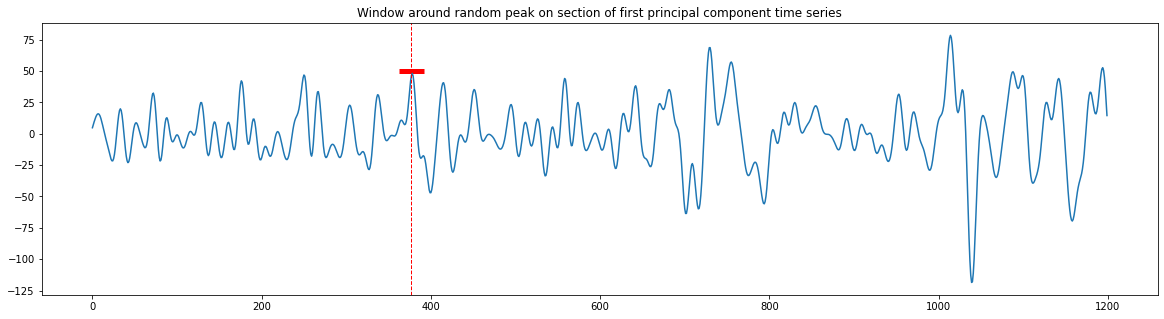

In [648]:
pca_ts = pickle.load(open('demo_files/pca_ts.pkl', 'rb'))
comp0_ts = pca_ts[:,0]
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(comp0_ts[:1200])
ax.set_title('Window around random peak on section of first principal component time series')
ax.axvline(377, linestyle='--', c='r', linewidth=1)
ax.hlines(50, xmin=362, xmax=392, linewidth=5, color='r')
plt.show()

<font size='4'>We compare the window-averaged BOLD signals and QPP dynamics, displayed as movies below:</font>

In [14]:
%%HTML
<table>
    <tr>
        <td>
            <header>
                <h4 style='text-align:center'>First Principal Component - Peak Average</h4>
            </header>
            <video controls autoplay loop width="550" height="500">                                                                
                <source                                                                     
                    src="demo_files/pca_rest_component0_text.mp4"
                    type="video/mp4"
            </video>
        </td>
        <td>
            <header>
                <h4 style='text-align:center'>Second Principal Component - Peak Average</h4>
            </header>
            <video controls autoplay loop width="550" height="500">                                                                
                <source                                                                     
                    src="demo_files/pca_rest_component1_text.mp4"
                    type="video/mp4">                                                       
            </video>
        
        </td>
    </tr>
    <tr>
        <td>
            <header>
                <h4 style='text-align:center'>Third Principal Component - Peak Average</h4>
            </header>
            <video controls autoplay loop width="550" height="500">                                                                
                <source                                                                     
                    src="demo_files/pca_rest_component2_text.mp4"
                    type="video/mp4">                                                       
            </video>
        s
        </td>
        <td>
            <header>
                <h4 style='text-align:center'>First Principal Component - Peak Average on GS Removed Signals</h4>
            </header>
            <video controls autoplay loop width="550" height="500">                                                                
                <source                                                                     
                    src="demo_files/pca_rest_component0_gs_text.mp4"
                    type="video/mp4">                                                       
            </video>
        
        </td>
    </tr>
    
</table>

<font size='4'> The window averaged BOLD movies emphasize the significant time-lag dynamics surrounding the peaks of the principal component time series. The time-lag dynamics of each principal component precisely match their corresponding phase offset map from the CHEOF analysis (<b>Sec 3.1.3</b>). The movies of each principal component have roughly the same overall time-lag pattern: peak BOLD amplitudes beginning in the sensorimotor, lateral visual and superior temporal cortices and ending in the DMN. This common time-lag behavior is precisely the overall time dynamics of the QPP. These findings further support the argument that these principal components, and all zero-lag analyses in <b>Sec 3.1</b> that resemble these principal components, are snapshots of the same temporally extended QPP pattern. The second and third principal component are predictably related to the first due to the spatial orthogonality constraints of PCA, and this is reflected in the he differing spatiotemporal properties of each principal component. As described in <b>Sec 3.1.3</b>, the time dynamics of the second principal component are a direct result of orthogonalizing with respect to the first principal component. It was shown that the continuous, smooth propagation pattern of the first principal component is replaced with an anti-phase switching behavior between the transition zone of the QPP and the DMN. This effectively shortens the propagation behavior of the QPP - i.e. the smooth propagation pattern that flows from beginning to end regions of the QPP is now represented by a 'fast' flow of positive peak BOLD amplitudes from the transition zone of the QPP to the DMN. This is exactly what is observed in the time-lag dynamics around the peaks of the second principal component time series: positive peak bold amplitudes in the transition zone of the QPP quickly propagate towards the DMN.</font>

<font size='4'> We observed in <b>Sec 3.1.3</b> that orthogonalizing with respect to the first principal component and global signal regression are equivalent. Thus, PCA on global signal regressed BOLD signals eliminates the original all-positive first principal component and replaces it with the anti-correlated second principal component. The second principal component does not reflect dynamics independent of the first principal component, but only gives an orthogonal redescription of that pattern. To illustrate this, we conducted peak averaging around the peaks of the first principal component time series <i>on global signal regressed data</i>. Global signal regression effectively orthogonalizes the BOLD signals with respect to the all-posiitive (or all-negative) first principal component. However, as easily observed in the window averaged BOLD signals of the global signal regressed data, global signal regression leaves the most of the time-dynamics of the first principal component intact. What is left over resembles the anti-correlated TP/TN pattern of the second principal component. In other words, global signal regression does not rid the data of global signal dynamics, it just produces an orthogonal, anti-correlated redescription of it. Of course, the first principal component is not accurately described as just a 'global signal', it corresponds to the global propagation period of a larger temporally extended pattern with multiple properties, the QPP.</font>
    
    
<font size='4'> The window averaged movies further emphasize that the static spatial patterns represent static snapshots of time-lagged dynamics. Standard PCA of zero-lag correlation/covariance matrices is unable to extract these dynamics. This is true of all static spatial patterns produced from analysis of zero-lag statistics. The significant time-lag dynamics around the peaks of the first three principal components emphasize that these patterns should not be physically interpreted as static connectivity phenomenon, but as snapshots of temporally extended, time-lagged dynamics. Further, we've argued that the dynamics associated with each of the snapshots are dynamics of a larger spatiotemporally extended QPP pattern.</font> 

## 3.3 CAPs Analysis and the QPP

<font size='4'> Co-activation pattern (CAP) analysis is a popular tool for studying resting-state BOLD dynamics. CAPs analysis identifies frequently re-occuring whole-brain spatial patterns across time points. It consists of two general steps: 1) given a seed time series, extract all vertex BOLD values at time points where the seed time series exceed a given threshold value, and 2) clustering of extracted time points into groups of time points with similar whole-brain spatial patterns. We applied CAPs analysis with two different seed regions - the precuneus and the somatosensory cortex. These seed regions correspond to beginning and end regions of the QPP, respectively. We followed the approach of Liu and Duyn (2013), and applied K-Means clustering to the time points of the seed time series greater than the 85th percentile (i.e. top 15% time points). We estimated a two cluster solution for each seed. As we've noted above, time point centering has an effect on the data similar to global signal regression. Specifically, both time-point centering and global signal regression remove the dominant direction of variance (first principal component) from the data, corresponding to the global propagation period of the QPP. To examine how time-point centering effects the spatial patterns returned from CAPs analysis, we computed K-means clustering with and without z-score normalization of time points (mean-centering and unit normalization). Note, without normalization, K-means implicitly operates on raw Euclidean distances between time points, which is sensitive to differences in scale.</font>
    
<font size='4'>As shown in <b>Sec 3.1</b>, the spatial patterns returned from CAPs analysis of precuneus and somatosensory seeds returns spatial patterns that resemble time points of the QPP pattern. In this section, we explore these findings further. Specifically, we explore why CAPs analysis returns these specific particular spatial patterns, and how they relate to the first three principal components of PCA. We projected the two-cluster CAPs solution for both the precuneus and somatosensory seeds onto the three principal component space. Specifically, we projected the suprathreshold time points (top 15% threshold) from the precuneus and somatosensory seeds onto the first three principal component axes, colored by each time points cluster assignment. Note, the cluster number for each CAPs analysis is arbitrary and there is no relationship between the cluster assignments of the two seeds. Additionally, we plotted the precuneus and somatosensory seed CAPs analysis for both the original and time-point normalized suprathreshold time points. Note, the suprathreshold time points are identical between the non-normalized and normalized data, the difference is purely whether each time point was normalized before application of the K-Means clustering algorithm.</font>

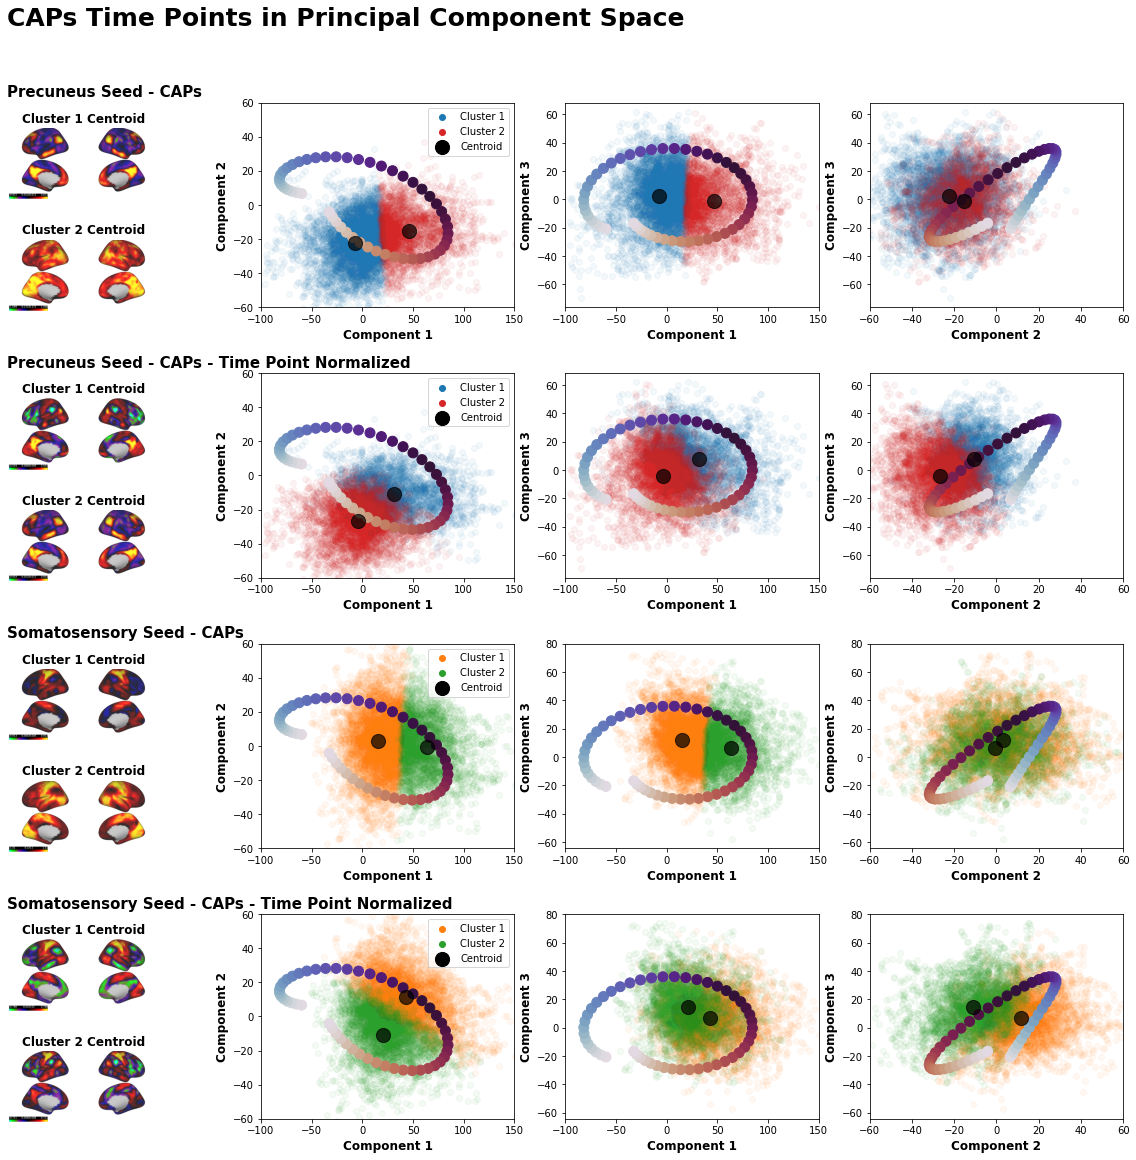

In [75]:
fps = [['demo_files/caps_precuneus_cluster0_c2.png', 'demo_files/caps_precuneus_cluster1_c2.png'],
       ['demo_files/caps_precuneus_norm_cluster0_c2.png', 'demo_files/caps_precuneus_norm_cluster1_c2.png'],
       ['demo_files/caps_sm_cluster0_c2.png', 'demo_files/caps_sm_cluster1_c2.png',], 
       ['demo_files/caps_sm_norm_cluster0_c2.png', 'demo_files/caps_sm_norm_cluster1_c2.png']]
section_labels = ['Precuneus Seed - CAPs', 'Precuneus Seed - CAPs - Time Point Normalized', 
                  'Somatosensory Seed - CAPs', 'Somatosensory Seed - CAPs - Time Point Normalized']
supra_thres_ts = pickle.load(open('demo_files/caps_suprathres_points.pkl', 'rb')) # X = USV
caps_p_res = pickle.load(open('results/caps_precuneus_results_c2.pkl', 'rb'))
caps_p_res_norm = pickle.load(open('results/caps_precuneus_norm_results_c2.pkl', 'rb'))
caps_sm_res = pickle.load(open('results/caps_sm_results_c2.pkl', 'rb'))
caps_sm_res_norm = pickle.load(open('results/caps_sm_norm_results_c2.pkl', 'rb'))

clus_labels_all = [caps_p_res[1], caps_p_res_norm[1], caps_sm_res[1], caps_sm_res_norm[1]]

fig = plt.figure(figsize=(20,20))
gspec = fig.add_gridspec(5,1, hspace=0.4, height_ratios=[0.005,0.2,0.2,0.2,0.2])

ax = fig.add_subplot(gspec[0:]); ax.axis('off')
ax.set_title('CAPs Time Points in Principal Component Space', fontsize=25, fontweight='bold', loc='left')

for indx in range(4):
    big_ax = fig.add_subplot(gspec[(indx+1):]); big_ax.axis('off')
    big_ax.set_title(section_labels[indx], fontsize=15, fontweight='bold', loc='left')

cm = plt.cm.get_cmap('tab20')
xy_ax_ord = [[0,1], [0,2], [1,2]]
color_list = [[cm(0), cm(6)], [cm(0), cm(6)], [cm(2), cm(4)], [cm(2), cm(4)]]
for i in range(4):
    if i < 2:
        time_points = supra_thres_ts[0]
    else:
        time_points = supra_thres_ts[1]
    colors = color_list[i]
    g_sub = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gspec[i+1], width_ratios=[0.15, 0.85])
    g_sub0 = gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=g_sub[0])
    g_sub1 = gridspec.GridSpecFromSubplotSpec(1,3, subplot_spec=g_sub[1])
    clus_labels = clus_labels_all[i]
    clus_1_indx = np.where(clus_labels == 0)[0]
    clus_2_indx = np.where(clus_labels == 1)[0]
    clus_1_centroid = np.mean(time_points[clus_1_indx, :],axis=0)
    clus_2_centroid = np.mean(time_points[clus_2_indx, :],axis=0)
    for indx, fp in enumerate(fps[i]):
        ax = fig.add_subplot(g_sub0[indx])
        img = mpimg.imread(fp)
        ax.set_title(f'Cluster {indx+1} Centroid', fontweight='bold')
        ax.imshow(img)
        ax.axis('off')
        pos1 = ax.get_position() # get the original position 
        pos2 = [pos1.x0, pos1.y0 - 0.01,  pos1.width, pos1.height] 
        ax.set_position(pos2) # set a new position
    for j in range(3):
        ax = fig.add_subplot(g_sub1[j])
        x, y = xy_ax_ord[j]
        ax.scatter(time_points[clus_1_indx,x], time_points[clus_1_indx,y], 
                   color=colors[0], alpha=0.05, label='Cluster 1')
        ax.scatter(time_points[clus_2_indx,x], time_points[clus_2_indx,y], 
                   color=colors[1], alpha=0.05, label='Cluster 2')
        im = ax.scatter(mssa_weights_proj[:,x], mssa_weights_proj[:,y], c=time_indx, cmap=plt.cm.twilight, s=100)
        ax.scatter(clus_1_centroid[x], clus_1_centroid[y], 
                    c='black', alpha=0.7, s=200, label='Centroid')
        ax.scatter(clus_2_centroid[x], clus_2_centroid[y], 
                    c='black', alpha=0.7, s=200)
        ax.set_xlabel(f'Component {x+1}', fontsize=12, fontweight='bold')
        ax.set_ylabel(f'Component {y+1}', fontsize=12, fontweight='bold')
        if x == 0:
            ax.set_xlim([-100, 150])
        elif x == 1:
            ax.set_xlim([-60, 60])
        if y == 1:
            ax.set_ylim([-60, 60])
        if j == 0:
            leg = ax.legend()
            for lh in leg.legendHandles: 
                lh.set_alpha(1)


<font size='4'> Visual examination of suprathreshold time points and cluster centroids in the three-dimensional principal component space reveals interesting insights into the relationship between the CAPs clusters, principal components, and the QPP. First, the location of suprathreshold time points is predictably related to the placement of the seed region. Placing the seed region in the beginning region of the QPP, the somatosensory cortex, extracts time points along the upper axis of the second principal component for both the original and time-point normalized data. Placing the seed region in the end region of the QPP, the DMN, extracts time points along the lower axis of the second principal component. There is heavy overlap between the clouds of time points between these two seeds, but the high density regions of the precuneus and somatosensory suprathreshold time points are relatively separated along the lower and upper axis of the second principal component. The centroid maps from each seed's CAPs analysis reflect their position along the second principal component axis. Seed placement in the somatosensory cortex returns time points where vertices in the beginning regions of the QPP are reaching peak positive BOLD amplitudes. Greater positive BOLD values in the beginning regions of the QPP are located in the upper right of the space formed by the first two principal components (<b>Sec 3.1.2</b>) (x=1, y=2). Thus, the centroid maps of the two-cluster solution for both original and normalized BOLD signals exhibit positive BOLD values in the beginning regions of the QPP. Seed placement in the precuneus returns time points where vertices in the end regions of the QPP, the DMN, are reaching peak positive BOLD amplitudes. Positive values in the in the DMN are located in the center bottom of the space formed by the first two principal components (<b>Sec 3.1.2</b>) (x=1,y=2). Thus, the centroid maps of the original and normalized data for the precuneus seed exhibit positive BOLD values in the end regions of the QPP, the DMN.</font>

<font size='4'> For the original, non-normalized cluster solutions, the two clusters from both seeds are clearly distinguished along the first principal component axis. In other words, for both precuneus and somatosensory seeds, the centroids of the two clusters vary exclusively along the principal component axis corresponding to the global propagation period of the QPP. Given the lack of clear cluster structure between suprathreshold time points from each seed, it is no surprise that the clustering algorithm separates suprathreshold time points along the principal component axis with greatest variance in the data. It is instructive to observe the change in cluster structure when the suprathreshold time points are normalized (i.e. mean centered and unit variance) for both seeds. For normalized cluster solutions, the cluster centroids primarily vary along the second principal component axis, corresponding to the TP/TN spatial pattern. In the case of the somatosensory seed, the normalized cluster centroids vary almost exclusively along the second principal component axis. In the case of the precuneus seed, the normalized cluster centroids vary partially along both the first and second principal component axes. This effect is entirely predictable from the time-point normalization operation. As we've shown above, time-point centering has a similar practical effect to global signal regression: the variance along the first principal component axis is significantly reduced (i.e. the variance due to the global propagation period of the QPP). The time-point normalization operation before the CAPs analysis involves mean-centering of each time point (along with unit normalization). Thus, the variance of the first principal component axis that originally separated the two cluster centroids for both seeds has been signficantly reduced or eliminated. What is left over is the variance along the second principal component axis, TP/TN pattern. The centroids of the data from both seeds now vary signficantly or exclusively on the second principal component axis.</font>

<font size='4'> Overall, the spatial patterns from CAPs analysis of the original and normalized BOLD signals seem to be the result of parsing BOLD time points along the the first or second principal component axis, respectively. The cloud of points formed by the suprathreshold time points from both seeds lacks a clear separation into two or more regions of high density in the space formed by three principal component axes. Rather, the cloud of suprathreshold time points is a continuous region of points that varies greatest along the first or second principal component, depending on whether normalization was performed. Thus, the two-cluster solution of CAPs divides this continuous cloud of points into two parts along the first principal component axis for the non-normalized data, and into two parts along the second principal component axis for the normalized the data. These findings further point to the non-trivial nature of time-point centering and/or global signal regression in analysis of resting-state BOLD signals. Time-point centering and global signal regression significantly reduce or eliminate the dominant axis of variance of cortex-wide BOLD signals. But as we've shown above, this does not mean that the dynamics described by this axis, the global propagation period of the QPP, have been eliminated from the data. Rather, the dynamics of the global propagation period are also reflected in the second principal component, though in a non-straightforward way.</font>

# WORK IN PROGRESS

    
    Individual time points are the basic units of analysis in CAPs analysis, rather than time series of individual vertices. Consider across-subject concatenated data as a 2D matrix $X_{ij}$, where i is the row index of time points, and j is the column index of vertices. Principal component analysis (PCA) operates on the covariance/correlation matrix formed by the correlation between the columns of $X$ - i.e. correlations between individual time series. CAPs analysis operates on the similarities/dissimilarities measured between the rows of $X$ - i.e. the similarity of vertex BOLD values between individual time points. The similarities/dissimilarities between time points are then input to a clustering algorithm to find frequently re-occuring spatial patterns across time points.Traditional CAPs analysis does not cluster all rows/time points of the matrix $X$, but selects rows based on a criterion applied to a seed region time series. The standard criterion is those time points of the seed region time series that exceed a certain threshold value, such as the 90th percentile of values. The clustering algorithm is then applied to those rows or time points of matrix $X$ corresponding to the suprathreshold time points of the seed region time series. As we've noted above, time point centering has an effect on the data similar to global signal regression. Specifically, both time-point centering and global signal regression remove the dominant direction of variance (first principal component) from the data, corresponding to the global propagation period of the QPP. This is an important consideration for CAPs analysis, where the choice of metric to measure the similarity/dissimilarity of time points is concerned. K-Means clustering implicitly uses Euclidean distances between time points (though no explicit computation of all pair-wise distances is computed). Euclidean distance between time points is sensitive the total magnitude and scale between the time points being compared. The original CAPs study (Liu and Duyn, 2013; PNAS) utilize an extension of K-Means with a correlation distance metric. Correlation ignores arbitrary magnitude and scaling differences between time points - i.e. the mean is removed from each vertex BOLD value and unit normalized within each time point. Given the similar practical effect of time point centering and global signal regression, we should expect the choice of preprocessing or similarity metric to have non-trivial effects on the results of CAPs analysis. 

In [385]:
%%capture 
# ^ supress printing
group_data_orig, hdr, zero_mask, _ = load_data_and_stack(50, 'gifti', global_signal=0)

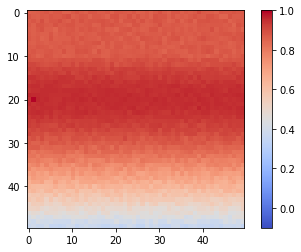

In [57]:
from sklearn.linear_model import LinearRegression
fc_map = []
for vertex_ts in mat_2d.T:
    lin_reg = LinearRegression()
    lin_reg.fit(mat_2d[:, 1001].reshape(-1, 1), 
                vertex_ts.reshape(-1, 1))
    fc_map.append(lin_reg.coef_[0][0])
fc_map = np.array(fc_map)
plt.imshow(fc_map.reshape(50,50), vmin=-0.1, vmax=1, cmap='coolwarm')
plt.colorbar()

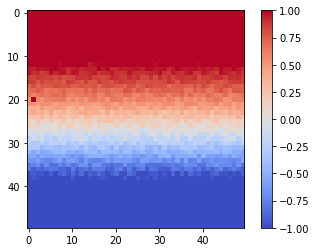

In [83]:
from sklearn.linear_model import LinearRegression
residual_ts_all = []
global_signal = mat_2d.mean(axis=1)
for vertex_ts in mat_2d.T:
        lin_reg = LinearRegression()
        lin_reg.fit(global_signal.reshape(-1, 1), 
                    vertex_ts.reshape(-1, 1))
        pred_ts = lin_reg.predict(global_signal.reshape(-1,1))
        residual_ts = vertex_ts.reshape(-1,1) - pred_ts
        residual_ts_all.append(residual_ts)
mat_2d_r = np.squeeze(np.array(residual_ts_all)).T

fc_map = []
for vertex_ts in mat_2d_r.T:
    lin_reg = LinearRegression()
    lin_reg.fit(mat_2d_r[:, 1001].reshape(-1, 1), 
                vertex_ts.reshape(-1, 1))
    fc_map.append(lin_reg.coef_[0][0])
fc_map = np.array(fc_map)
plt.imshow(fc_map.reshape(50,50), vmin=-1, vmax=1, cmap='coolwarm')
plt.colorbar()

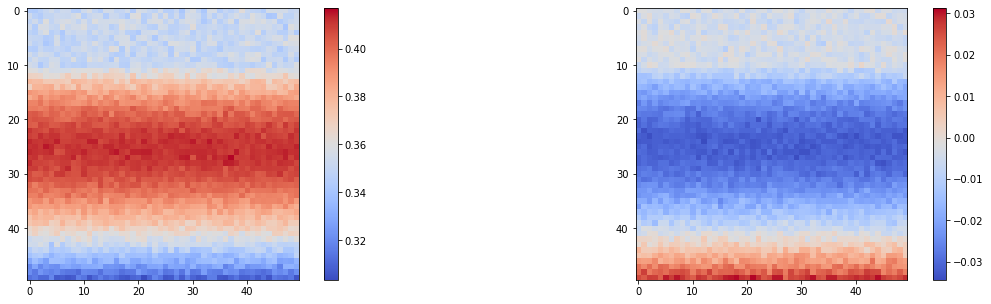

In [73]:
from run_cap_analysis import get_suprathreshold_maps, cluster_maps
selected_tps, selected_maps = get_suprathreshold_maps(mat_2d[:,1001], mat_2d, 85)
clus_centers, clus_labels = cluster_maps(mat_2d, False, 2)
clus_centers_norm, clus_labels_norm = cluster_maps(mat_2d, True, 2)

fig, axs = plt.subplots(1,2, figsize=(20,5))
for n in range(2):
    im = axs[n].imshow(clus_centers[n,:].reshape(50,50), cmap='coolwarm')
    fig.colorbar(im, ax=axs[n])
plt.show()


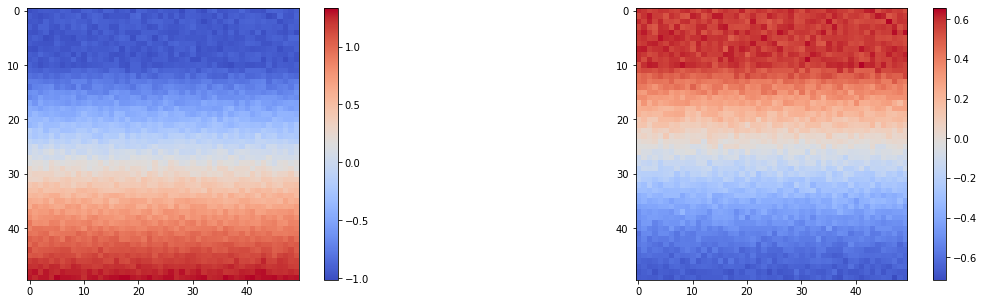

In [75]:
fig, axs = plt.subplots(1,2, figsize=(20,5))
for n in range(2):
    im = axs[n].imshow(clus_centers_norm[n,:].reshape(50,50), cmap='coolwarm')
    fig.colorbar(im, ax=axs[n])
plt.show()

# <b>Appendix</b>

## Appendix A - Two Major Axes of Zero-Lag Spatial Map Similarity

<font size='4'> Visual observation of the spatial maps produced from popular zero-lag analyses indicates a strong correspondence in their spatial patterns. Further, comparison of these spatial maps with time points of the QPP indicates these maps resemble 'snapshots' of the QPP. To organize the large number of spatial similarity judgments above into a coherent structure, we used a multidimensional scaling approach. We projected both the time points of the QPP derived from the EEOF analysis (n=50) and the zero-lag spatial maps into the same 2-dimensional similarity space using a metric multidimensional scaling algorithm. Specifically, we projected the pair-wise Euclidean distances between all QPP time point spatial maps (t=1,2,...,50) and zero-lag spatial maps onto the samp 2-dimensional space constructed to preserve the relative distances between each pair of spatial maps. In this 2-dimensional space, the Euclidean distance represents the similarity/dissimilarity between the spatial patterns between each map. For reference, the spatial maps at each time point of the QPP are colored using a cyclical color map, from time point 0 to time point 50. In addition, spatial maps of chosen time points in the QPP are displayed beside their corresponding time point location in the 2-dimensional space.  Note, all spatial maps were z-score normalized before computation of the Euclidean distances to remove arbitrary magnitude differences.</font>

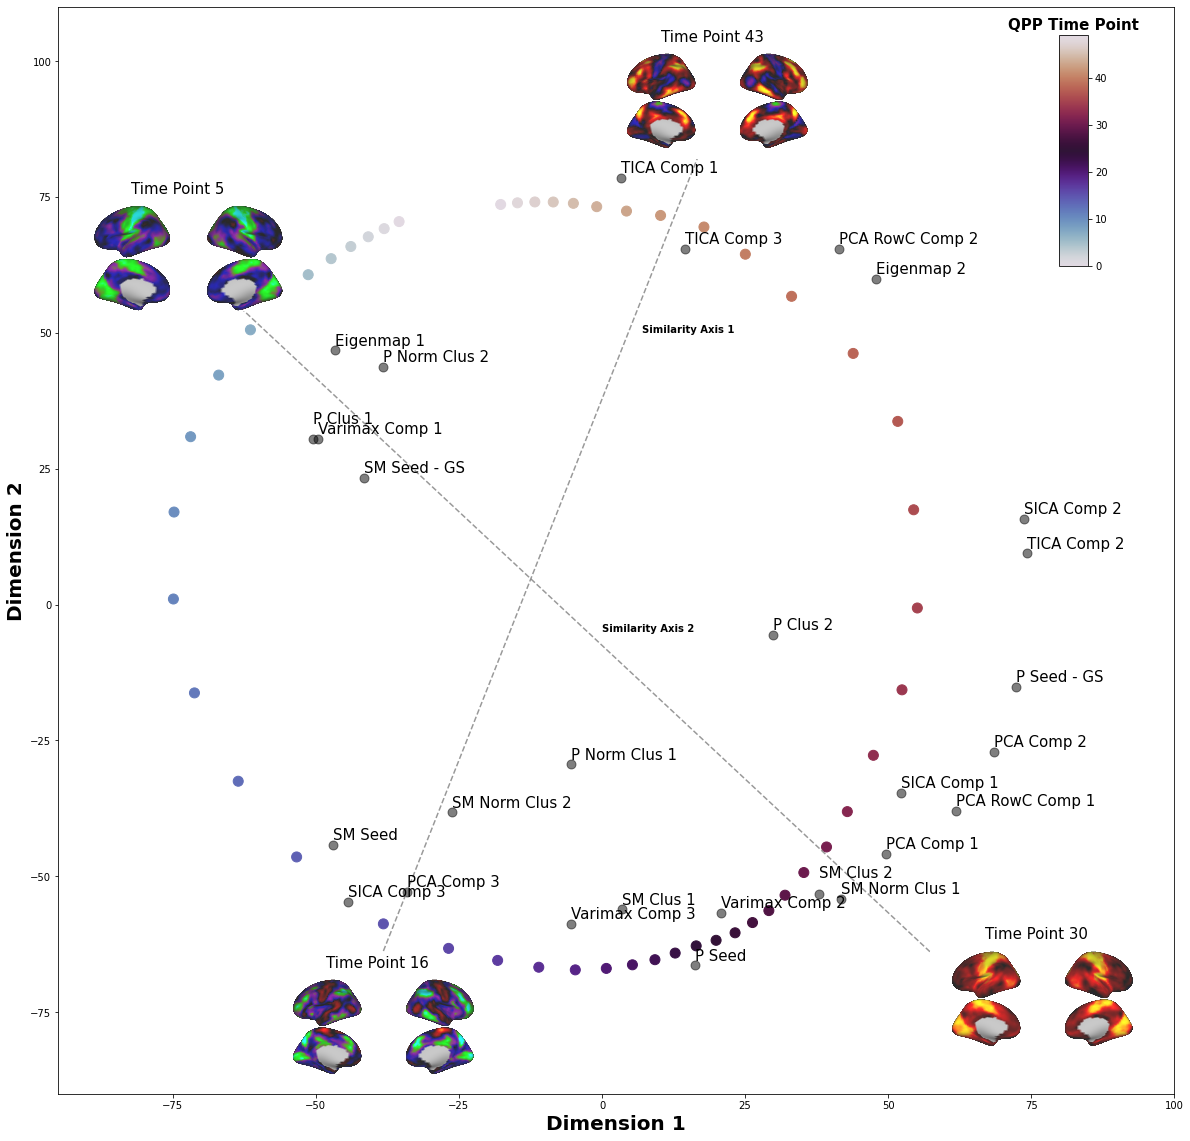

In [468]:
cifti_fps = (
    'demo_files/pca_rest.dtseries.nii', 'demo_files/pca_tmode_rest.dtseries.nii', 
    'demo_files/diffusion_embedding.dtseries.nii', 'demo_files/pca_rest_varimax.dtseries.nii',
    'demo_files/fc_map_precuneus.dtseries.nii', 'demo_files/fc_map_gs_precuneus.dtseries.nii',
    'demo_files/fc_map_sm.dtseries.nii', 'demo_files/fc_map_gs_sm.dtseries.nii', 
    'demo_files/s_ica.dtseries.nii', 'demo_files/t_ica.dtseries.nii', 
    'demo_files/caps_precuneus_c2.dtseries.nii', 'demo_files/caps_precuneus_norm_c2.dtseries.nii',
    'demo_files/caps_sm_c2.dtseries.nii', 'demo_files/caps_sm_norm_c2.dtseries.nii'
)
labels_short = (
    'PCA Comp 1', 'PCA Comp 2', 'PCA Comp 3', 'PCA RowC Comp 1', 'PCA RowC Comp 2',
    'Eigenmap 1', 'Eigenmap 2', 'P Seed', 'P Seed - GS', 'SM Seed', 'SM Seed - GS',
    'Varimax Comp 1', 'Varimax Comp 2', 'Varimax Comp 3', 'SICA Comp 1', 'SICA Comp 2', 
    'SICA Comp 3', 'TICA Comp 1', 'TICA Comp 2', 'TICA Comp 3', 'P Clus 1', 'P Clus 2', 
    'P Norm Clus 1', 'P Norm Clus 2', 'SM Clus 1', 'SM Clus 2', 'SM Norm Clus 1', 
    'SM Norm Clus 2'
)

cifti_maps_all = []
for fp in cifti_fps:
    _, cifti_maps, n_time = pull_cifti_data(load_cifti(fp))
    if any([label in fp for label in ['pca_rest', 'ica']]):
        cifti_maps_all.append(cifti_maps[:3, :])
    else:
        cifti_maps_all.append(cifti_maps[:2, :])
cifti_maps_all = np.vstack(cifti_maps_all)
zero_mask = np.std(cifti_maps_all, axis=0) > 0
zero_mask_indx = np.where(zero_mask)[0]
cifti_maps_all = cifti_maps_all[:, zero_mask].copy()

_, mssa_weights, _ = pull_cifti_data(load_cifti('demo_files/mssa_comp0_w50.dtseries.nii'))
mssa_weights = mssa_weights[:, zero_mask]

all_maps = np.vstack([mssa_weights, cifti_maps_all])
comp_scores = PCA(n_components=50).fit_transform(zscore(all_maps.T).T)
mds = MDS(random_state=1)
mds.fit(comp_scores)
embeddings = mds.embedding_
time_indx = np.arange(50)


fig, ax = plt.subplots(figsize=(20,20))

img_indx = [4, 15, 29, 42]
shift_x = [-25, 0, 45, 10]
shift_y = [0, -20, -20, 20]
for indx, x_s, y_s in zip(img_indx, shift_x, shift_y):
    x, y = embeddings[indx,0], embeddings[indx, 1]
    ab = AnnotationBbox(getImage(f'demo_files/mssa_comp0_w50_t{indx+1}.png'), 
                        (x+x_s, y+y_s), frameon=False)
    ax.add_artist(ab)
    ax.text(x+x_s-10, y+y_s+12, f'Time Point {indx+1}', fontsize=15)

ax1_coord = [(embeddings[img_indx[0],0]+shift_x[0], embeddings[img_indx[2],0] + shift_x[2]-15), 
             (embeddings[img_indx[0],1]+shift_y[0], embeddings[img_indx[2],1] + shift_y[2]+5)]
ax2_coord = [(embeddings[img_indx[1],0]+shift_x[1], embeddings[img_indx[3],0] + shift_x[3]), 
             (embeddings[img_indx[1],1]+shift_y[1]+15, embeddings[img_indx[3],1] + shift_y[3])]
ax.plot(ax1_coord[0], ax1_coord[1], '--', c='grey', alpha=0.8)
ax.plot(ax2_coord[0], ax2_coord[1], '--', c='grey', alpha=0.8)

s = ax.scatter(embeddings[:50,0], embeddings[:50,1], s=100, c=time_indx, cmap=plt.cm.twilight)
cbar = plt.colorbar(s, ax=ax, cax = fig.add_axes([0.82, 0.7, 0.02, 0.16]))
cbar.ax.set_title('QPP Time Point', fontsize=15, fontweight='bold')

ax.scatter(embeddings[50:,0], embeddings[50:, 1], s=80, c='black', alpha=0.5) 
for i, label in enumerate(labels_short):
    if label in ['SM Clus 2', 'P Clus 1']:
        y_shift=3
    else:
        y_shift=1
    ax.annotate(label, (embeddings[50+i,0], embeddings[50+i,1]+y_shift), fontsize=15)
ax.text(0,-5, 'Similarity Axis 2', fontweight='bold')
ax.text(7,50, 'Similarity Axis 1', fontweight='bold')

ax.set_ylim(-90, 110)
ax.set_xlim(-95, 100)
ax.set_xlabel('Dimension 1', fontsize=20, fontweight='bold')
ax.set_ylabel('Dimension 2', fontsize=20, fontweight='bold')
plt.show()

<font size='4'> The time points of the QPP derived from the EEOF analysis are represented in this 2-dimensional similarity space as an elongated circle. The temporal progression of the QPP is represented as a counter-clockwise progression around this circle. Interestingly, all of the spatial maps produced from zero-lag anlaysis are observed to be closely dispersed around the circle formed by the QPP in the 2-dimensional space. The majority of the zero-lag spatial maps are arranged on two non-orthogonal axes of the 2-dimensional similarity space. The majority of the spatial maps seem to be arranged on the axis stretching from the top left to the bottom right, labeled <i> similarity axis 2</i>. Zero-lag maps that cluster around the 'bottom' of this axis exhibit positive activation in the beginning regions of the QPP, and less positive or negative values in the end regions of the QPP (i.e. the DMN). Zero-lag maps that cluster around the 'top' of this axis exhibit the exact opposite pattern. The QPP time points located at each end of the pattern are a global negative pattern (time point 5) and a global positive pattern (time point 30). Note, the zero-lag maps that cluster around similarity axis 2 contain both unipolar (all positive) and bipolar spatial patterns (positive/negative). We return to this observation in later sections. Zero-lag maps distributed on the two ends of similarity axis 1 correspond to the two transition periods between the two global all-positive/all-negative pattern. These spatial maps are marked by a smaller region of positive/negative activation in the beginning regions of the QPP and a different spatial pattern of negative/positive activation in the DMN (i.e ending region) compared to the spatial maps distributed along axis 2.</font>

<font size='4'> The findings from the multidimensional scaling analysis further confirm the visual observations made above: the spatial patterns produced by zero-lag analyses strongly resemble static snapshots of the QPP's spatiotemporal propagation pattern.</font>

## Appendix B - Temporal Similarity of Zero-Lag Analysis Output

<font size='4'> While the spatial maps exhibit strong similarities, it's still possible for the time courses of these spatial patterns to exhibit different dynamics. Some of these analyses collapse across the time dimension or use a kernel transformation, and do not provide time courses - i.e. seed-based correlation analysis, CAPs analysis, and Laplacian Eigenamps. Those analyses that do yield time courses include PCA, rotation-based PCA analyses, and temporal and spatial ICA. To examine the similarities in time courses between the components returned from these analyses, we computed the correlations between each pair of component time series and display them below in a correlation matrix:</font> 

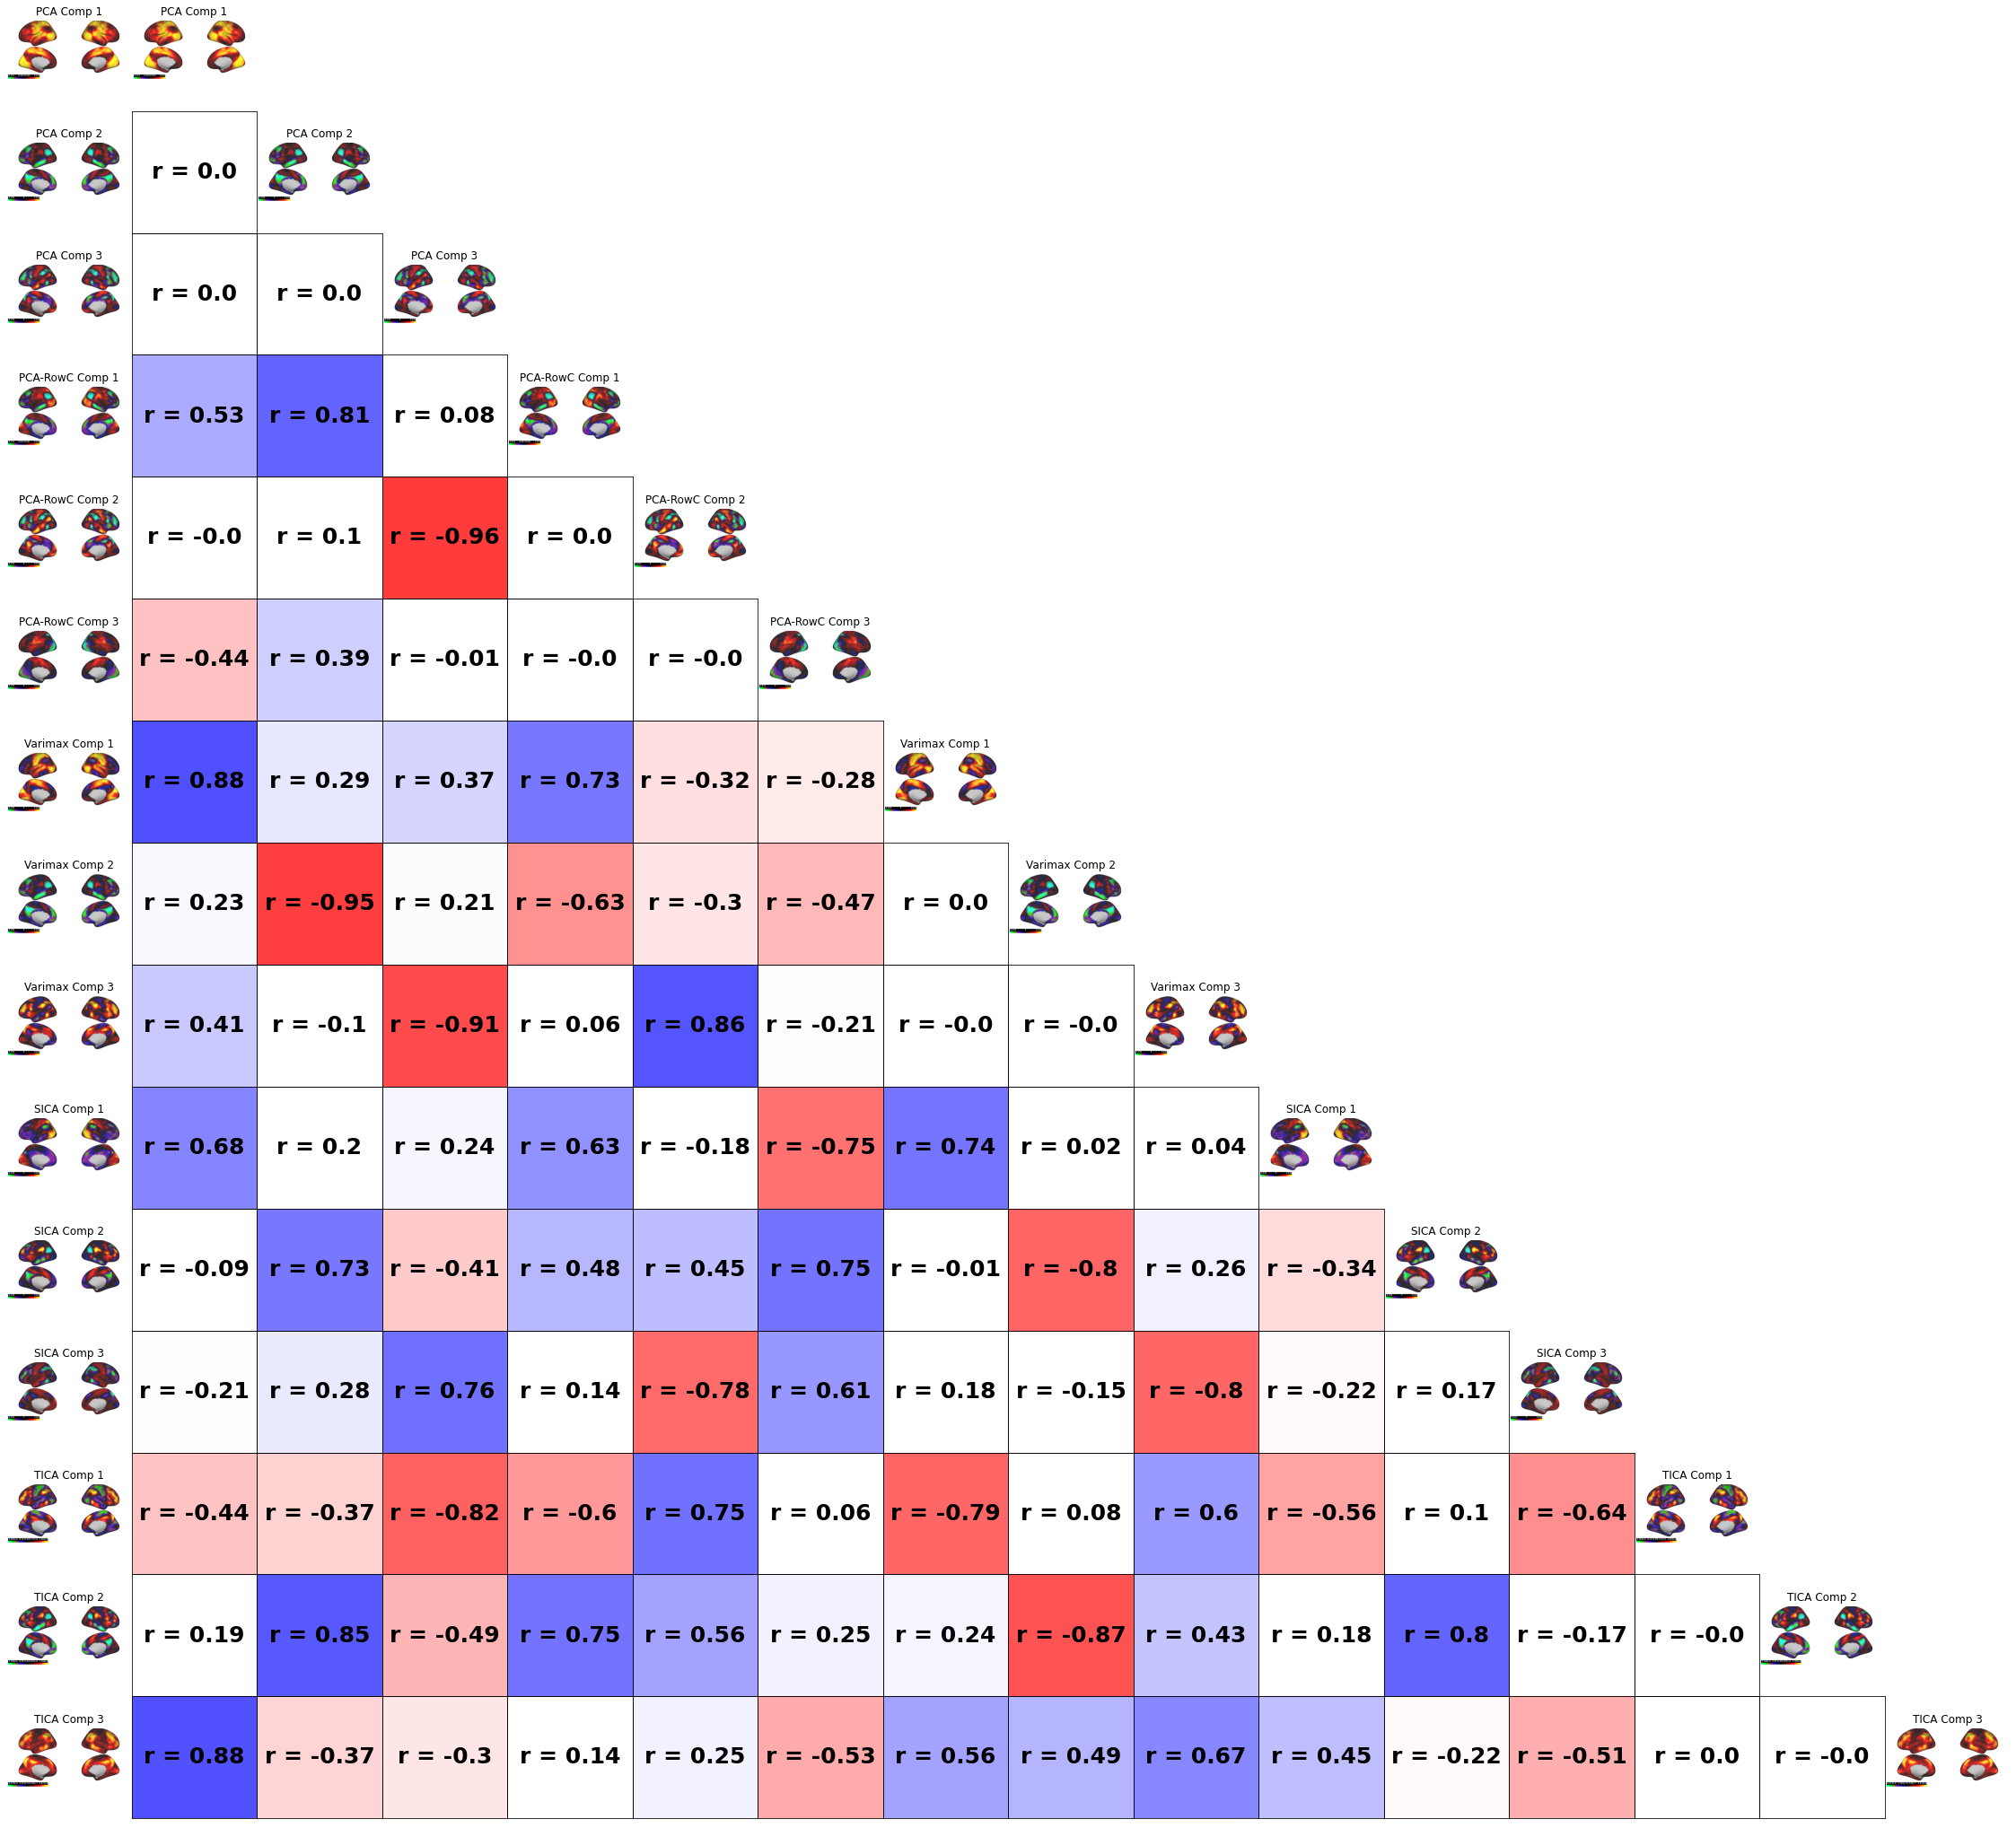

In [120]:
pca_ts = pickle.load(open('demo_files/pca_ts.pkl', 'rb'))
pcar_ts = pickle.load(open('demo_files/pcar_ts.pkl', 'rb'))
tica_ts = pickle.load(open('demo_files/tica_ts.pkl', 'rb'))
sica_ts = pickle.load(open('demo_files/sica_ts.pkl', 'rb'))
varimax_ts = pickle.load(open('demo_files/varimax_ts.pkl', 'rb'))

comp1_pca, comp2_pca, comp3_pca = pca_ts[:,0], pca_ts[:,1], pca_ts[:,2]
comp1_pcar, comp2_pcar, comp3_pcar = pcar_ts[:,0], pcar_ts[:,1], pcar_ts[:,2]
comp1_varimax, comp2_varimax, comp3_varimax = varimax_ts[:,0], varimax_ts[:,1], varimax_ts[:,2]
comp1_tica, comp2_tica, comp3_tica = tica_ts[:,0], tica_ts[:,1], tica_ts[:,2]
comp1_sica, comp2_sica, comp3_sica = sica_ts[:,0], sica_ts[:,1], sica_ts[:,2]

fps = ['demo_files/pca_rest_comp0.png', 'demo_files/pca_rest_comp1.png', 'demo_files/pca_rest_comp2.png', 
       'demo_files/pca_tmode_rest_comp0.png', 'demo_files/pca_tmode_rest_comp1.png', 'demo_files/pca_tmode_rest_comp2.png', 
       'demo_files/pca_rest_varimax_comp0.png', 'demo_files/pca_rest_varimax_comp1.png', 
       'demo_files/pca_rest_varimax_comp2.png', 'demo_files/spatial_ica_comp0.png', 'demo_files/spatial_ica_comp1.png', 
       'demo_files/spatial_ica_comp2.png', 'demo_files/temporal_ica_comp0.png', 'demo_files/temporal_ica_comp1.png', 
       'demo_files/temporal_ica_comp2.png']
labels = ['PCA Comp 1', 'PCA Comp 2', 'PCA Comp 3', 'PCA-RowC Comp 1', 'PCA-RowC Comp 2', 'PCA-RowC Comp 3', 
          'Varimax Comp 1', 'Varimax Comp 2', 'Varimax Comp 3', 'SICA Comp 1', 'SICA Comp 2', 'SICA Comp 3',
          'TICA Comp 1', 'TICA Comp 2', 'TICA Comp 3']
all_comps = [comp1_pca, comp2_pca, comp3_pca, comp1_pcar, comp2_pcar, comp3_pcar, 
             comp1_varimax, comp2_varimax, comp3_varimax, comp1_sica, comp2_sica,
             comp3_sica, comp1_tica, comp2_tica, comp3_tica]

corr_mat = np.corrcoef(all_comps)

fig = plt.figure(figsize=(40, 40))
grid = gridspec.GridSpec(16, 16, wspace=0.0, hspace=0.0)
for indx, (fp, label) in enumerate(zip(fps, labels)):
    axr = fig.add_subplot(grid[indx+1,0])
    axc = fig.add_subplot(grid[indx+1, indx+1])
    img = mpimg.imread(fp)
    axr.set_title(label); axc.set_title(label)
    axr.imshow(img); axc.imshow(img)
    axr.axis('off'); axc.axis('off')
    
br_col = [None, 'blue', 'red']
for i in range(15):
    for j in range(i):
        if i != j:
            ax = fig.add_subplot(grid[i+1, j+1])
            r = corr_mat[i,j]
            r_sign = np.int(np.sign(r))
            ax.text(0.5, 0.5, f'r = {np.round(r, 2)}',
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=25, fontweight='bold',
            transform=ax.transAxes)
            ax.patch.set_facecolor(br_col[r_sign])
            ax.patch.set_alpha(max(0,r*r_sign-0.2))
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
        else:
            ax = fig.add_subplot(grid)

plt.show()

<font size='4'> As with the spatial maps, the time courses between the components of each analysis reveal striking similarities. In fact, all of the component time courses exhibit strong correlations with at least one of the component time courses from another analysis. The findings from both the spatial maps and time courses indicate that these analyses are capturing very similar phenomena. </font>

## Appendix C - PCA and Non-Linear Manifold Learning

<font size='4'> PCA is a well-known eigendecomposition approach in fMRI research. More importantly, it is related to a wide variety of analytic approaches popular in the fMRI literature. In fact, PCA is closely related to the recent resurgence of eigendecomposition methods in resting-state fMRI analysis that has gone under the name of 'functional connectivity gradients'. The seminal study of functional connectivity gradients by Margulies et al. (2016 - PNAS) introduced the concept of connectivity gradients to the study of resting-state fMRI. To derive functional connectivity gradients, manifold learning algorithms, such as diffusion map embedding (as in Margulies et al. 2016) and Laplacian Eigenmaps, are applied to a vertex-by-vertex similarity/kernel matrix (or voxel-by-voxel). A fixed number of dimensions or manifolds are returned from the manifold learning algorithm, representing orthogonal sub-spaces that preserve the distances (in a Euclidean sense) between vertices/voxels. PCA has a very close relationship with these approaches. Both diffusion maps and Laplacian Eigenmaps involve an eigendecomposition of a modified similarity matrix, the graph Laplacian, analagous to the covariance/correlation matrix used by PCA. Further, these techniques can be viewed as special cases of kernel PCA, PCA extended to an arbitrary kernel/similarity matrix. We computed the first three Laplacian Eigenmaps from the vertex-by-vertex cosine similarity matrix, and compared them to the first three principal components from PCA and PCA of time-point normalized data (i.e. z-score normalized across all the vertices within a time point). Note, Laplacian Eigenmaps with a radial basis function kernel (non-linear kernel) was also tried and the results were very similar.</font>

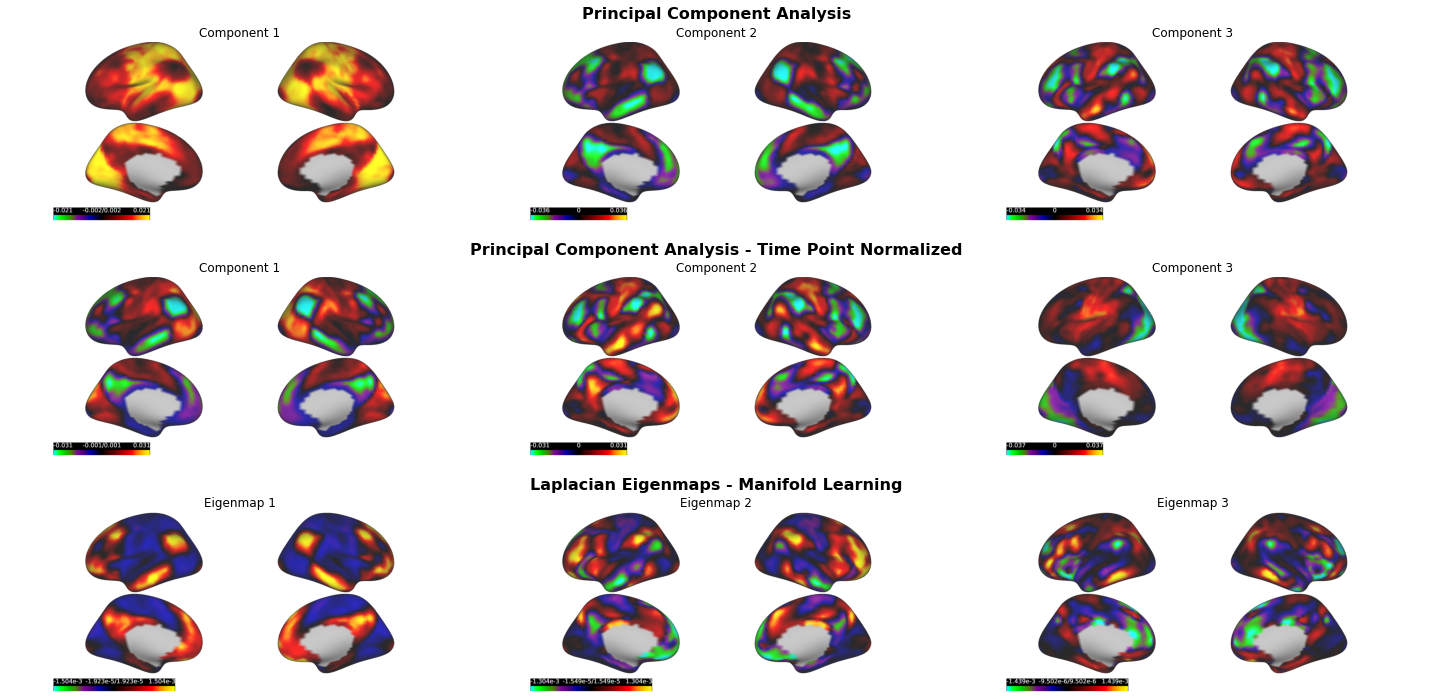

In [218]:
fps = [['demo_files/pca_rest_comp0.png', 'demo_files/pca_rest_comp1.png', 'demo_files/pca_rest_comp2.png'],
       ['demo_files/pca_tmode_rest_comp0.png', 'demo_files/pca_tmode_rest_comp1.png', 'demo_files/pca_tmode_rest_comp2.png'],
       ['demo_files/diffusion_emb_comp0.png', 'demo_files/diffusion_emb_comp1.png', 'demo_files/diffusion_emb_comp2.png']]
labels = [['Component 1', 'Component 2', 'Component 3'],
          ['Component 1', 'Component 2', 'Component 3'],
          ['Eigenmap 1', 'Eigenmap 2', 'Eigenmap 3']]
section_labels = ['Principal Component Analysis', 
                  'Principal Component Analysis - Time Point Normalized',
                  'Laplacian Eigenmaps - Manifold Learning']

fig, big_axes = plt.subplots(figsize=(20, 10) , nrows=3, ncols=1, sharey=True) 

for row, (big_ax, section_labels) in enumerate(zip(big_axes, section_labels), start=1):
    big_ax.set_title(f"{section_labels}\n", fontsize=16, fontweight='bold')
    # Turn off axis lines and ticks of the big subplot 
    big_ax.axis('off')
    
indx = 0
for i, (fp_sec, label_sec) in enumerate(zip(fps, labels)):
    for j in range(3):
        indx += 1
        ax00 = fig.add_subplot(3, 3, indx)
        if j <= (len(fp_sec) - 1):
            img = mpimg.imread(fp_sec[j])
            ax00.set_title(label_sec[j])
            ax00.imshow(img)
        ax00.axis('off')

fig.set_facecolor('w')
plt.tight_layout()
plt.show()

<font size='4'> The first and second Laplacian Eigenmap match the second and third principal components from the PCA solution, respectively. The difference between the PCA and Laplacian Eigenmap solution is that the first principal component seems to be missing from the Laplacian Eigenmap solution. However, the first three components from the PCA applied to the time-point normalized data do match the three Laplacian Eigenmaps (w/ an arbitrary sign flip). These similarities between the spatial maps produced by PCA and Laplacian Eigenmaps has been previously observed by Vox de Waal et al. (2020; Nature Comm. Biology). Vox de Waal et al. (2020) also observed that diffusion map embedding returned equivalent results to the Laplacian Eigenmap solution. Thus, the non-linear manifold learning seems to return results similar to a linear principal component analysis.</font>
 
<font size='4'> As we note in the main text, the first principal component correspond to the globally positive and negative propagation event of the QPP. The time points of the QPP vary greatest along the first principal component axis. Thus, it is interesting that the Laplacian Eigenmap solution does not recover a pattern resembling this component. In the main text, we demonstrate the potential mixing of the temporal dynamics of the QPP across the first and second principal component. Specifically, the global propagation dynamics of the QPP seems to vary across both the first and second principal component. In fact, the Pearson correlation between the first and second principal components is <i>r=0.7</i>. This can be observed visually in the figure above: compare the spatial weights between the first and second principal component from the ordinary PCA solution, the first principal component with the first Laplacian Eigenmap, and the first principal component with the first principal component from the PCA applied to time-normalized data.</font>
    
    
<font size='4'>The question is why is the first principal component, the variance upon which BOLD time series vary the greatest, is not returned by Laplacian Eigenmaps and the PCA applied to time-point normalized data? In both cases, the difference is due to the same mechanism: mean-centering along the time domain (i.e. mean centering vertex BOLD values within a time point). We explore the interaction between time-point centering, global signal regression and the first principal component in the main text. For now, we note time-point centering is explicit in the time-point normalized data - vertex values are mean-centered within each time point (and divided by the standard deviation). In the Laplacian Eigenmap solution, the time-point centering is not so explicit. If we have a matrix $X_{ij}$, where $i$ indexes observations and $j$ indexes variables, manifold learning algorithms are conventionally described as projection of the <i>observations</i> (rows) into a low-dimensional space that preserves the local and/or global distances between the observations. Implicit in the steps of many of these algorithms is a mean-centering in the <i>feature space</i> or mean-centering of the variables (Ham et al. 2004; ICML). Note, in manifold learning this mean centering is done directly on the kernel/similarity matrix rather than the original matrix $X$. This is analogous to the double centering operation of a distance matrix to produce the Gram matrix in classical multidimensional scaling. In other words, manifold learning of a time point-by-time point kernel matrix assumes a mean centering of the feature space, i.e. each vertex/voxel is mean centered. In the context of functional connectivity gradients, non-linear manifold learning algorithms are applied directly to the <i>vertex-by-vertex</i> affinity/kernel matrix. In the case of Laplacian Eigenmaps, this implies an implicit mean centering of the <i>time points</i>, i.e. the vertex BOLD values within a time point are mean-centered. As we show in the main text, this has the same practical effect as global signal regression. Given that PCA of time-point normalized data and Laplacian eigenmaps both conduct a time-point centering, we observe that they return the same results (besides an arbitrary sign difference).</font>

## Appendix D -  Global BOLD Propagation Simulation

<font size='4'> To gain further insight into the properties of zero-lag analyses applied to propagating fields, we created a simple simulation framework. Simple impulse time series (1 for activation, 0 otherwise) convolved with the canonical hemodynamic response are spatially arranged along a square grid. The time series are arranged such that time series in the top part of the square grid peak early, and peak later and later (time steps of 0.1 secs per row) as one moves down the grid. This arrangement provides a simple illustration of a global propagation event, where activity in one location travels to all other locations in a spatially continuous fashion. Gaussian noise is added to every time point of each time series, and slight phase and amplitude jitter are applied to each time series within a row of the square grid drawn from a uniform distribution. The global propagation event in the simulation is re-run 1000 times and sampled at the sampling frequency of the HCP scans (0.72 TRs). It is important to note that this simulation is NOT intended to be a biologically realistic simulation of the mechanisms that produce observed BOLD propagation patterns. The intent of this simulation is illustrate the properties of zero-lag analyses applied to fields containing globally propagating phenomena. While this simulation is designed to have superficial similarities to spatial and temporal properties of the QPP, it does not intend to simulate its underlying <i>data generating process</i>. Below we display the first 35 time points of the global BOLD propagation simulation:

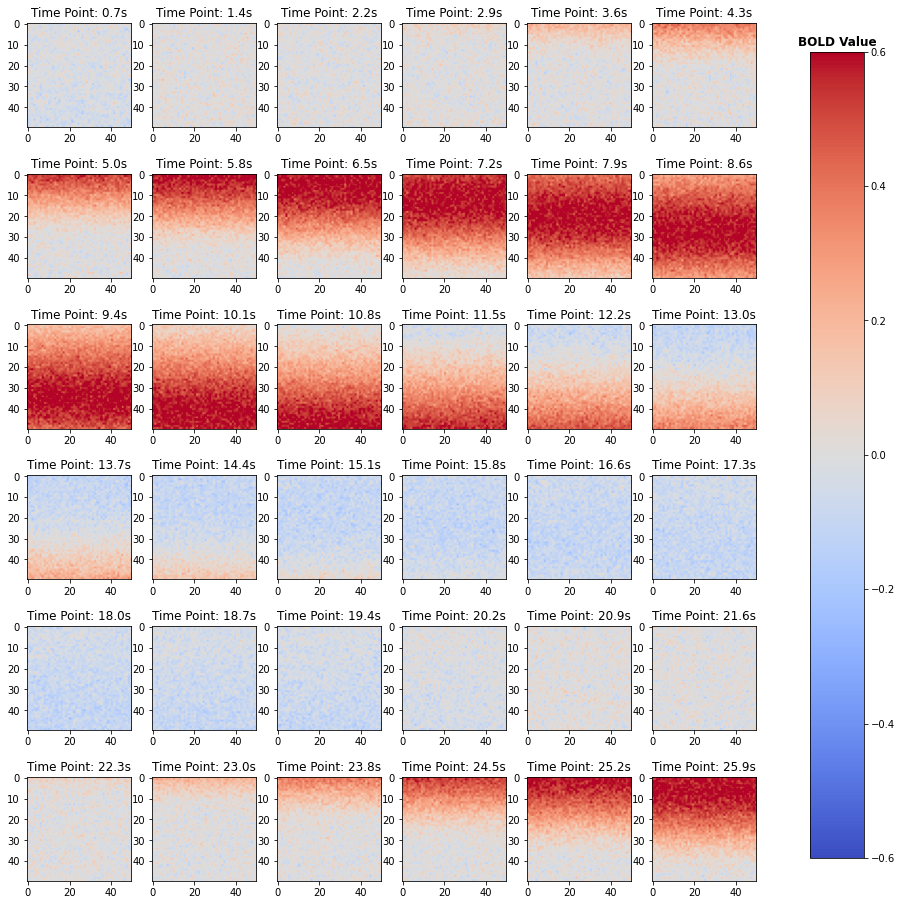

In [641]:
std_noise = 0.05; # noise-to-signal ratio
n_per_shift = 50
ts_len = 2000  
phase_jitter=10
amplitude_jitter=0.5
phase_shift = 10
start = 50
ts_sampling=0.01
n_repeats=500
n_resample = np.int(ts_len*ts_sampling/tr)*n_repeats

# static_region_begin = range(0,10)
travel_region = range(50)
# static_region_end = range(40,50)

all_ts_begin = np.zeros((50,50,n_resample))

indx = 0

# for n in static_region_begin:
#     all_ts[indx,:,:] = create_hrf_group(n_per_shift, start, ts_len, tr, 1, phase_jitter, amplitude_jitter, ts_sampling, n_repeats)
#     all_ts[indx,:,:] += np.array([std_noise*rand.randn(all_ts.shape[2]) for n in range(n_per_shift)])
#     indx += 1

for i, n in enumerate(travel_region):
    all_ts[indx,:,:] = create_hrf_group(n_per_shift, start, ts_len, tr, 1, phase_jitter, amplitude_jitter, ts_sampling, n_repeats)
    all_ts[indx,:,:] += np.array([std_noise*rand.randn(all_ts.shape[2]) for n in range(n_per_shift)])
    start += phase_shift
    indx += 1

# for n in static_region_end:
#     all_ts[indx,:,:] = create_hrf_group(n_per_shift, start, ts_len, tr, 1, phase_jitter, amplitude_jitter, ts_sampling, n_repeats)
#     all_ts[indx,:,:] += np.array([std_noise*rand.randn(all_ts.shape[2]) for n in range(n_per_shift)])
#     indx += 1

all_ts_2d = [(all_ts[i,j,:], (i,j)) for i in range(all_ts.shape[0]) for j in range(all_ts.shape[1])]
mat_2d = np.array([ts[0] for ts in all_ts_2d]).T

fig, ax = plt.subplots(6,6,figsize=(15,16))

for i, ax in enumerate(fig.axes):
    im = ax.imshow(all_ts[:,:,i], cmap='coolwarm', vmin=-0.6, vmax=0.6)
    ax.set_title(f'Time Point: {round((i+1)*tr,1)}s')

fig.subplots_adjust(right=0.8, hspace=0.3)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title("BOLD Value", fontsize=12, fontweight='bold')
plt.show()

<font size='4'> The first 20 time points of the simulation illustrate the simulated global propagation event: peak BOLD amplitudes are first observed in the top of the square grid, followed by a subsequent propagation of peak BOLD amplitudes down the grid. Following the globally positive BOLD propagation event, there is a mirrored negative BOLD propagation event due to the post-response undershoot of the canonical hemodynamic response function. This simulation contains superficial similarities with the spatiotemporal dynamics of the QPP - a positive peak amplitudes that propagate across the entire cortex, followed by a mirrored negative propagation event. As emphasized above, this is not intended as a biologically realistic simulation of the mechanism by which the QPP arises, but as a simple simulation of a globally propagating BOLD field. In the sections that follow, we apply the zero-lag analyses examined above to this simple propagation simulation to gain insights into the properties of their outputs, and their relationship to the QPP.</font>

### Appendix D1 - Principal Components of Global Propagation Simulation

<font size='4'>The orthogonality constraint of eigenvector decomposition can yield predictable patterns for the components following the first component. For example, if the weights of the first principal component are unipolar (i.e. all positive or all negative), the second component will generally be bipolar with its zero value passing through the highest value point in the first component; this will generally be followed a more complex, multipolar pattern of weights in third component with maxima near zero-points of the first and second components. This is exactly what is observed between the first three principal components of resting-state BOLD signals: following the unipolar all-positive first principal component, the second principal component is bipolar, with weight values near zero in the somatosensory cortex, the area of maximum weight values in the first component.</font>

    
<font size='4'>To emphasize the predictability of these patterns, we applied PCA to the simulated global propagation patterns. The weights for the first three principal components are displayed in the figure above. We see the exact same progression of patterns in the first three principal components of the simulation compared to the resting-state BOLD time series. The first componenet captures the global propagation pattern with an all unipolar positive component, followed by a bipolar pattern in the second component, and a multipolar pattern in the third principal component.</font>

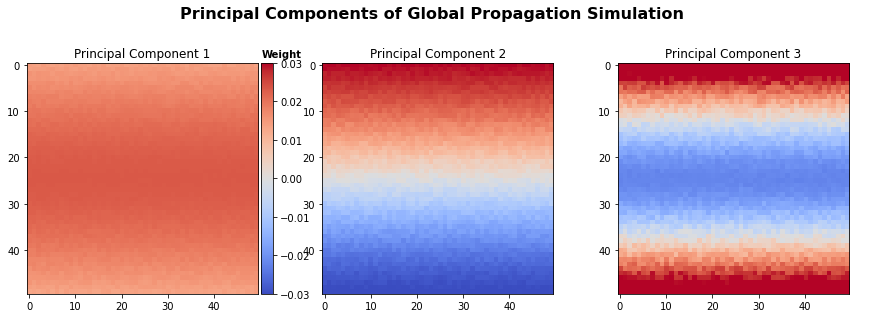

In [642]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Principal Components of Global Propagation Simulation', fontsize=16, fontweight='bold')
pca = PCA(n_components=3)
pca.fit(zscore(mat_2d))
for n in range(3):
    im = axs[n].imshow(pca.components_[n,:].reshape(50,50), vmin=-0.03, vmax=0.03, cmap='coolwarm')
    axs[n].set_title(f'Principal Component {n+1}')
    divider = make_axes_locatable(axs[n])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    if n == 0:
        cbar = plt.colorbar(im, cax=cax)
        cbar.ax.set_title("Weight", fontsize=10, fontweight='bold', loc='left')
    else:
        cax.axis('off')

## Appendix E - Time Point Centering and Global Signal Regression

<font size='4'>The time dynamics of the QPP maximally vary along the first principal component axis, corresponding to the globally positive and negative propagation periods of the QPP. Further, the time series of the first principal component is identical with the time series of the mean of whole-brain BOLD signals at each time point. For many zero-lag analysis results displayed in <b>Sec 2.1</b>, an all-positive or all-negative spatial map resembling the first principal componet is not observed. The primary reason is that these analyses involve a global signal regression or time point centering pre-processing step (the missing all positive/negative first principal component in the Laplacian Eigenmap solution is discussed in <b>Appendix C</b>). </font>

<font size='4'> As Liu et al. (2017; Neuroimage) have previously observed, regression of the mean signal from each vertex, and subtraction of the mean signal ('global signal subtraction' or 'time-point centering') from each vertex has very similar practical effects on the data. This is particularly the case for vertices that closely track the global signal. In fact, when the fit coefficient between the global signal and a vertex time series is 1, both operations have the same effect on that vertices' signal. They observed that posterior cingular cortex (PCC) seed correlation maps between global signal regressed and time-point centered data are very similar across subjects. Both maps exhibit the same anticorrelated TP/TN pattern. In other words, both global signal regression and time-point centering eliminate the all-positive (all-negative) correlation pattern. To illustrate this point, we display the first three principal components from the time-point centered and global signal regressed data:</font>

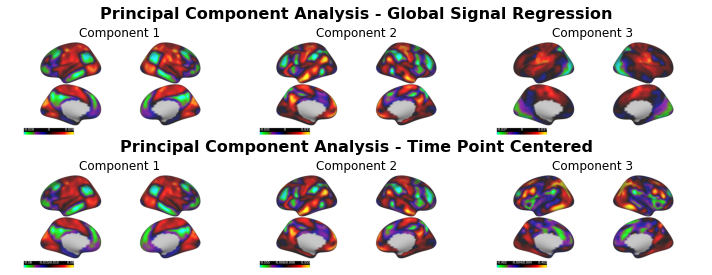

In [565]:
fps = [['demo_files/pca_rest_gs_comp0.png', 'demo_files/pca_rest_gs_comp1.png', 'demo_files/pca_rest_gs_comp2.png'],
       ['demo_files/pca_tmode_rest_comp0.png', 'demo_files/pca_tmode_rest_comp1.png', 'demo_files/pca_tmode_rest_comp2.png']]
labels = [['Component 1', 'Component 2', 'Component 3'],
          ['Component 1', 'Component 2', 'Component 3']]
section_labels = ['Principal Component Analysis - Global Signal Regression', 
                  'Principal Component Analysis - Time Point Centered']

fig, big_axes = plt.subplots(figsize=(10, 4) , nrows=2, ncols=1, sharey=True) 

for row, (big_ax, section_labels) in enumerate(zip(big_axes, section_labels), start=1):
    big_ax.set_title(f"{section_labels}\n", fontsize=16, fontweight='bold')
    # Turn off axis lines and ticks of the big subplot 
    big_ax.axis('off')
    
indx = 0
for i, (fp_sec, label_sec) in enumerate(zip(fps, labels)):
    for j in range(3):
        indx += 1
        ax00 = fig.add_subplot(2, 3, indx)
        if j <= (len(fp_sec) - 1):
            img = mpimg.imread(fp_sec[j])
            ax00.set_title(label_sec[j])
            ax00.imshow(img)
        ax00.axis('off')

fig.set_facecolor('w')
plt.tight_layout()
plt.show()

<font size='4'> PCA of the time-point centered and global-signal regressed data yields identical results. In both cases, the all-positive first principal component from the original resting-state BOLD signals is replaced by the second principal component. Only in the case of the third principal component does there seem to be some differentiation in the principal component solutions between each preprocessing step. However, even with the third principal component, a very similar spatial distribution is observed (ignored the sign-flip between the components). The identification of global signal regression with the behavior of centering along the temporal axis has non-trivial implications for the interpretaion of analyses of resting-state BOLD signals. Time-point centering step is an implicit step in a great many zero-lag analyses: eigendecomposition of graph Laplacians (e.g. Laplacian Eigenmaps), spatial ICA, and CAPs analysis. However, its rare for the effects of global signal regression to be considered in these contexts. Given both the controversy of global signal regression and the the similar practical effects of time-point centering, much more attention should be given to the effects of time-point centering in these anlayses. In the main text, we pay close attention to the potential effects of this step on analyses of resting-state BOLD signals, and their relation to the QPP.</font>
   

## Appendix F - Rotation of Principal Components 

<font size='4'> Eigenvector decompositions of cortical BOLD signals mix similar dynamics of the QPP across their components. However, eigendecomposition techniques represent only one of the many popular zero-lag analyses applied to resting-state BOLD signals. Spatial and temporal independent component analysis (ICA) are also popular analysis approaches in the resting-state fMRI literature. In relation to principal components derived from PCA, spatial and temporal ICA amounts to a rotation (i.e. unmixing matrix) of the whitened temporal or spatial principal component axes such that the statistical independence between the axes is maximized, respectively. In other words, ICA rotates the original PCA solution to maximize a different criterion: statistical independence in the temporal or spatial domain. 'Independence' is a stronger criterion than the orthogonal or uncorrelatedness assumption of PCA. Independence implies uncorrelatedness, but the converse is not always true. Thus, for the original three component PCA solution, we could estimate a three component temporal ICA solution by rotating the principal component axes (<b>Sec 3.1.2</b>) in the temporal domain towards statistical independence. If we wanted to estimate a three component spatial ICA solution, we could rotate the first three whitened principal component axes derived from PCA of the time point-by-time point covariance/correlation matrix. In this conception, ICA is one of a larger family of principal component rotation methods that includes rotations towards so-called 'simple structure'. Simple structure rotations rotate the principal component loadings so that the sparsity of the loadings are maximized (each vertex loads strongly on only one component). One popular simple structure rotation is the so-called 'varimax' rotation - an orthogonal rotation of the principal component loadings that maximizes sparsity.</font>
    
<font size='4'>All of these rotation methods drop one or more of the restrictive constraints of the principal component solution: 1) orthogonality of the spatial eigenvectors, 2) uncorrelatedness of component time series, or 3) the criterion of maximum variance. The question is whether these rotation methods of the principal component axes or loadings matrix return spatial/temporal components that belong to physically distinct spatiotemporal dynamics. As shown visually in <b>Sec 3.1</b>, temporal and spatial ICA, and varimax rotation return components with roughly similar spatial properties to the original first three principal components. To provide a more quantitative assessment of similarities, we again display the spatial weights of the three-component rotated solutions, along with their spatial and temporal correlations with the first three principal components. In addition, we display the first three principal component spatial weights from the original and global-signal regressed BOLD time series. To further illustrate how each rotation method relates to the global propagation period of the QPP, we projected a random selection of time points from the original BOLD time series into each of the rotated three-component spaces. Each time point is colored according to their position along the first principal component axis from cool (global negative propagation) to warm (global positive propagation). Examination of the colored time points in each rotated component space provides information regarding the relationship between the rotated components and the global propagation period of the QPP. Note, the coloring of each time point along the first principal component axis is fixed - i.e. each time point maintains it original color mapping along the first principal component in the rotated component space.</font>

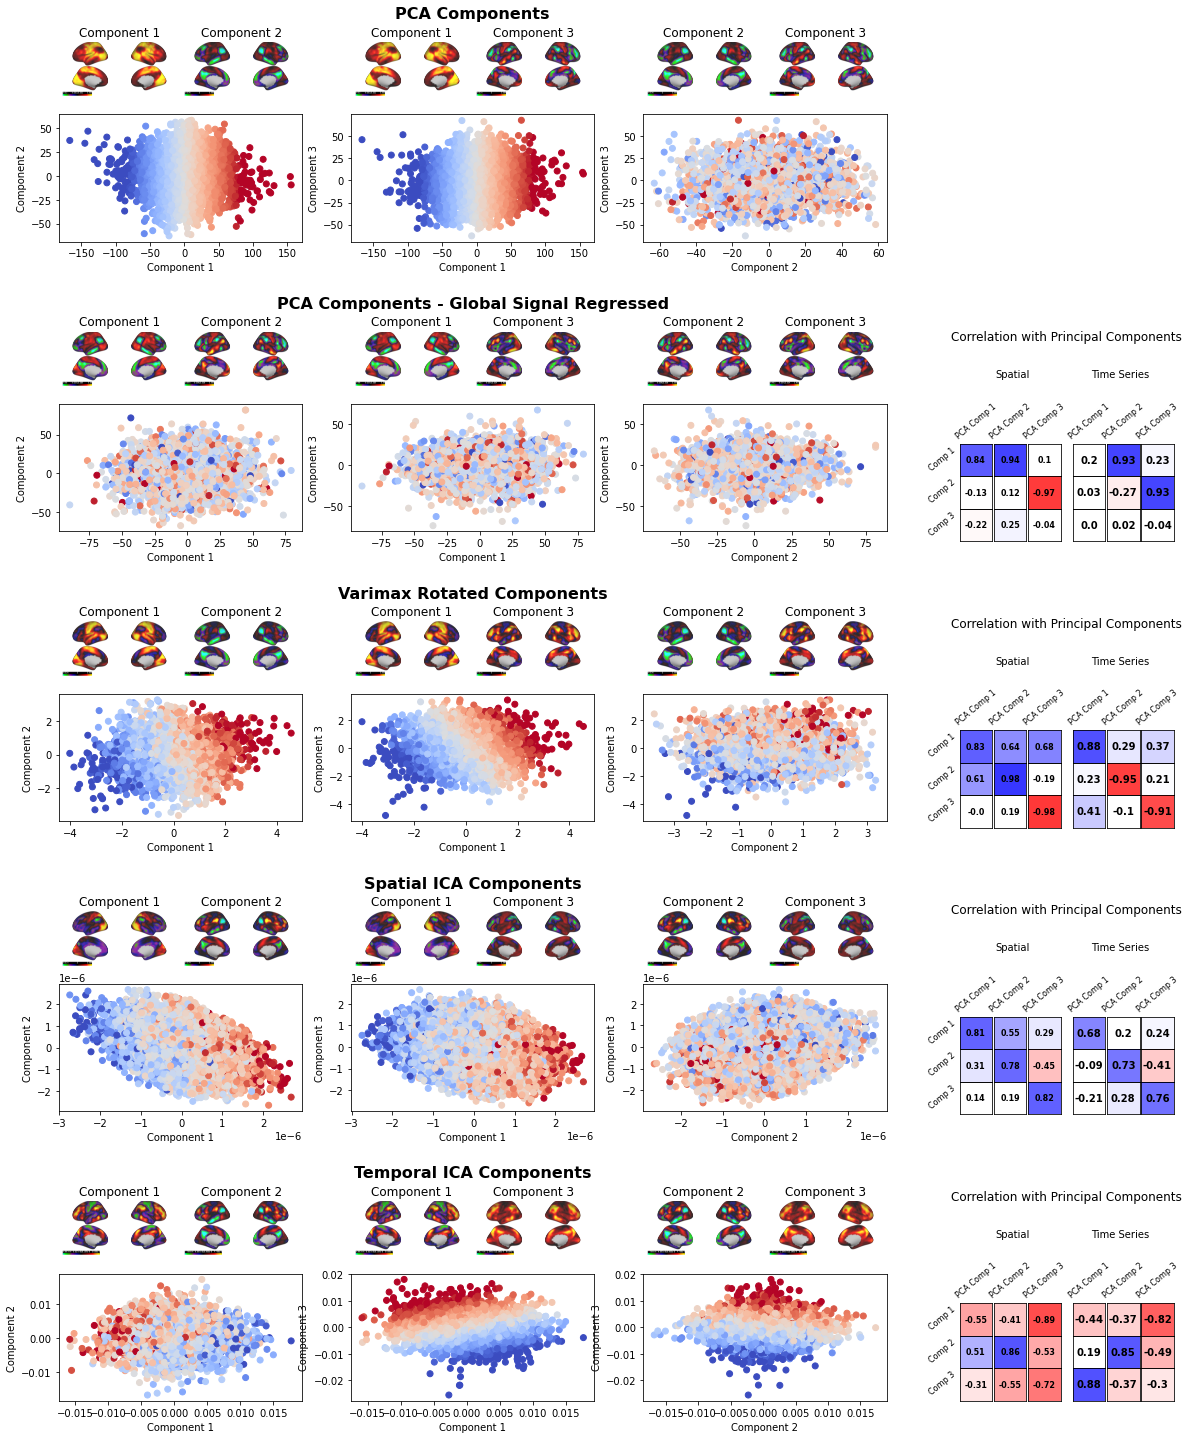

In [567]:
fps = [['demo_files/pca_rest_comp0.png', 'demo_files/pca_rest_comp1.png', 'demo_files/pca_rest_comp2.png'], 
       ['demo_files/pca_tmode_rest_comp0.png', 'demo_files/pca_tmode_rest_comp1.png', 'demo_files/pca_tmode_rest_comp2.png'], 
       ['demo_files/pca_rest_varimax_comp0.png', 'demo_files/pca_rest_varimax_comp1.png', 'demo_files/pca_rest_varimax_comp2.png'], 
       ['demo_files/spatial_ica_comp0.png', 'demo_files/spatial_ica_comp1.png', 'demo_files/spatial_ica_comp2.png'], 
       ['demo_files/temporal_ica_comp0.png', 'demo_files/temporal_ica_comp1.png', 'demo_files/temporal_ica_comp2.png']]
cifti_fps = ['demo_files/pca_rest.dtseries.nii', 'demo_files/pca_tmode_rest.dtseries.nii', 
             'demo_files/pca_rest_varimax.dtseries.nii', 'demo_files/s_ica.dtseries.nii', 
             'demo_files/t_ica.dtseries.nii']
section_labels = ['PCA Components', 'PCA Components - Global Signal Regressed', 'Varimax Rotated Components', 
                  'Spatial ICA Components', 'Temporal ICA Components']

cifti_maps_all = []
for fp in cifti_fps:
    _, cifti_maps, n_time = pull_cifti_data(load_cifti(fp))
    cifti_maps_all.append(cifti_maps[:3, :])
cifti_maps_all = np.vstack(cifti_maps_all)
zero_mask = np.std(cifti_maps_all, axis=0) > 0
zero_mask_indx = np.where(zero_mask)[0]
cifti_maps_all = cifti_maps_all[:, zero_mask].copy()
spatial_corr = np.corrcoef(cifti_maps_all)

pca_ts = pickle.load(open('demo_files/pca_ts.pkl', 'rb'))
pca_ts_gs = pickle.load(open('demo_files/pca_gs_ts.pkl', 'rb'))
varimax_ts = pickle.load(open('demo_files/varimax_ts.pkl', 'rb'))
tica_ts = pickle.load(open('demo_files/tica_ts.pkl', 'rb'))
sica_ts = pickle.load(open('demo_files/sica_ts.pkl', 'rb'))
all_ts = [pca_ts, pca_ts_gs, varimax_ts, sica_ts, tica_ts]
time_corr = np.corrcoef(np.hstack(all_ts).T)

rand_indx = rand.permutation(pca_ts.shape[0])[:5000]
pc_scores = pca_ts[rand_indx, :]
pc_gs_scores = pca_ts_gs[rand_indx, :]
varimax_scores = varimax_ts[rand_indx, :]
sica_scores = sica_ts[rand_indx,:]
tica_scores = tica_ts[rand_indx,:]
all_ts_sample = [pc_scores, pc_r_scores, varimax_scores, sica_scores, tica_scores]

perc_99 = round(np.percentile(pc_scores[:,0],99), 2)
perc_1 = round(np.percentile(pc_scores[:,0],1), 2)

fig = plt.figure(figsize=(20,25), constrained_layout=False)
gspec = fig.add_gridspec(5,1, wspace=0.5, hspace=0.45)
gspec2 = fig.add_gridspec(5,2, wspace=0.2)

for row, label in enumerate(section_labels):
    big_ax = fig.add_subplot(gspec[row,:])
    big_ax.set_title(f"{label}\n", fontsize=16, fontweight='bold')
    # Turn off axis lines and ticks of the big subplot 
    big_ax.axis('off')

indx=3
br_col = [None, 'blue', 'red']
xy_ax_ord = [[0,1], [0,2], [1,2]]

for i, (ts, fp) in enumerate(zip(all_ts_sample, fps)): 
    g_sub0 = gridspec.GridSpecFromSubplotSpec(2,3, subplot_spec=gspec[i], hspace=0.2)
    for n in range(3):
        sub_grid = g_sub0[:,n].subgridspec(2,2, wspace=0, height_ratios=[0.3,0.7])
        ax1 = fig.add_subplot(sub_grid[0,0])
        img = mpimg.imread(fp[xy_ax_ord[n][0]])
        ax1.set_title(f'Component {xy_ax_ord[n][0]+1}', fontsize=12)
        ax1.imshow(img)
        ax1.axis('off')

        ax2 = fig.add_subplot(sub_grid[0,1])
        img = mpimg.imread(fp[xy_ax_ord[n][1]])
        ax2.set_title(f'Component {xy_ax_ord[n][1]+1}', fontsize=12)
        ax2.imshow(img)
        ax2.axis('off')

        ax3 = fig.add_subplot(sub_grid[1,:])
        x_ts = ts[:,xy_ax_ord[n][0]]
        y_ts = ts[:,xy_ax_ord[n][1]]
        ax3.scatter(x_ts, y_ts, c=pc_scores[:,0], cmap='coolwarm', vmin=perc_1, vmax=perc_99)
        ax3.set_xlabel(f'Component {xy_ax_ord[n][0]+1}', fontsize=10)
        ax3.set_ylabel(f'Component {xy_ax_ord[n][1]+1}', fontsize=10)
#         asp_ratio = (np.max(y) - np.min(y))/(np.max(x) - np.min(x))
        pos1 = ax3.get_position() # get the original position 
        pos2 = [pos1.x0, pos1.y0 + 0.01,  pos1.width, pos1.height] 
        ax3.set_position(pos2) # set a new position

    if i > 0:
        g_sub_lg = gridspec.GridSpecFromSubplotSpec(2,2, subplot_spec=gspec2[i, :], hspace=0, wspace=0.1)
        g_sub0 = gridspec.GridSpecFromSubplotSpec(2,2, subplot_spec=g_sub_lg[0, :], hspace=0, wspace=0)
        g_sub1 = gridspec.GridSpecFromSubplotSpec(3,3, subplot_spec=g_sub_lg[1, 0], hspace=0, wspace=0)
        g_sub2 = gridspec.GridSpecFromSubplotSpec(3,3, subplot_spec=g_sub_lg[1, 1], hspace=0, wspace=0)
        big_ax_title = fig.add_subplot(g_sub0[0,:])
        big_ax_title.set_title(f"Correlation with Principal Components", fontsize=12)
        big_ax_title.axis('off')
        big_ax = fig.add_subplot(g_sub0[1,0])
        big_ax.set_title(f"Spatial\n", fontsize=10)
        big_ax.axis('off')
        big_ax = fig.add_subplot(g_sub0[1,1])
        big_ax.set_title(f"Time Series\n", fontsize=10)
        # Turn off axis lines and ticks of the big subplot 
        big_ax.axis('off')
        for x in range(3):
            for y in range(3):
                ax1 = fig.add_subplot(g_sub1[x, y])
                ax2 = fig.add_subplot(g_sub2[x, y])
                r_space = spatial_corr[indx,y]
                r_time = time_corr[indx,y]
                r_sign_space = np.int(np.sign(r_space))
                r_sign_time = np.int(np.sign(r_time))
                ax1.text(0.5, 0.5, f'{np.round(r_space, 2)}',
                         horizontalalignment='center',
                         verticalalignment='center',
                         fontsize=8, fontweight='bold',
                         transform=ax1.transAxes)
                ax2.text(0.5, 0.5, f'{np.round(r_time, 2)}',
                         horizontalalignment='center',
                         verticalalignment='center',
                         fontsize=10, fontweight='bold',
                         transform=ax2.transAxes)
                ax1.patch.set_facecolor(br_col[r_sign_space]); 
                ax2.patch.set_facecolor(br_col[r_sign_time])
                ax1.patch.set_alpha(max(0,r_space*r_sign_space-0.2))
                ax2.patch.set_alpha(max(0,r_time*r_sign_time-0.2))
                ax1.axes.xaxis.set_visible(False); ax2.axes.xaxis.set_visible(False);
                ax1.axes.yaxis.set_visible(False); ax2.axes.yaxis.set_visible(False);
                ax1.set_aspect('equal'); ax2.set_aspect('equal')
                if x == 0:
                    t = ax1.set_title(f'PCA Comp {y+1}', fontsize=8)
                    t.set_rotation(40)
                    t = ax2.set_title(f'PCA Comp {y+1}', fontsize=8)
                    t.set_rotation(40)
                if y == 0:
                    t = ax1.text(-1, 0.2, f'Comp {x+1}', fontsize=8)
                    t.set_rotation(40)

            indx+=1

gspec.update(right=0.7)
gspec2.update(left=0.75, hspace=0.47, top=0.87)
plt.show()

<font size='4'> Each rotated component maps closely to one or more of the principal components from the unrotated PCA solution. Specifically, each component of the rotated solution exhibits a strong spatial or temporal correlation with one or more of the first three principal components. In the majority of cases, there is a one-to-one mapping between each rotated component and each principal component. In some cases, two rotated components map closely to the same principal component in the spatial or temporal domain. For example, components 1 and 3 from the temporal ICA solution exhibit strong spatial correlation with the third principal component (<i>r=-0.89</i> and <i>r=-0.72</i>, respectively). However, the same components exhibit distinct temporal correlations: temporal ICA component 1 is most strongly associated with principal component 3 (<i>r=-0.82</i>), and component 3 with principal component 1 (<i>r=0.88</i>).</font>
    
<font size='4'> As shown in <b>Sec 3.1.2</b>, the global propagation period of the QPP varies most prominently along the first principal component axis of the original PCA solution. Global signal regression effectively eliminates variance along the original first principal component axis, as illustrated in the principal component solution on global signal regressed data. Colored time points within the first three principal component space of the global signal regressed data are randomly scattered. Rotation of the original principal component axes tends to redistribute the variance of the first principal component axis along one or more of the rotated components. For the temporal ICA and varimax solutions, the variance along the original first principal component is clearly redistributed along component 3 and component 1, respectively. The three components of the spatial ICA solution are non-orthogonal, but the variance of the original first principal component is most prominently isolated along ICA component 1. Examination of each rotated component space provides interesting insights into the spatiotemporal properties of the first three principal components when the constraints of PCA are relaxed. In the varimax rotation of the principal components, the orthogonality of the spatial loadings of the original PCA solution is dropped. These constraints are replaced with an objective to maximize sparsity of the spatial loadings. While the variance of the original first principal component is most clearly redistributed along the varimax rotated component 1, it also varies along rotated component 3. In fact, the variance of the original first principal component is most clearly separated within the two-dimensional space formed by varimax rotated components 1 and 3. In this space, the two ends of the first principal component axis are in the top-right and bottom-left of the space formed by the two rotated components. In other words, the variance along the original first principal component axis is now being partially shared between components 1 and 3 in the varimax component space.  A similar observation is observed in the temporal ICA solution: the variance of the original first principal component axis is partially shared between components 1 and 3 (note, the ordering of the components is arbitrary in these rotated spaces). The spatial loading patterns of varimax components 1 and 3 closely map to the first and third principal components in the original PCA solution, respectively. The spatial loading patterns of temporal ICA components 1 and 3 closely map to the third and first principal components in the original PCA solution, respectively. We noted previously that the first principal component corresponds to the global propagation period of the QPP, and the third principal components corresponds to the transition period of the QPP. However, in the rotated spaces of temporal ICA and the varimax rotation, the global propagation period and transition period of the QPP seem to be best characterized as mixtures of rotated components.</font>

<font size='4'> The variance of the original first principal component axis varies most prominently along component 1 in the spatial ICA solution. However, relative to the temporal ICA and varimax solutions, there is not a clear separation of the two ends of the first principal component axis along any of the component spaces formed by the spatial ICA components. In fact, the time series of component 1 in the varimax solution and component 3 in the temporal ICA solution is correlated with the first principal component at <i>r=0.88</i> and <i>r=0.88</i>, respectively; but the time series of component 1 in the spatial ICA solution is significantly less correlated with the first principal component time series at <i>r=0.68</i>. Thus, one might suggest that the spatial ICA solution 'ignores' the global propagation period of the QPP in its solution. But this is not a property of spatial ICA. Rather, it is a property of the prewhitening step before the ICA rotation. The prewhitening step of spatial ICA involves PCA of the time point-by-time point correlation/covariance matrix. In the time point-by-time point correlation matrix all the BOLD values within a time point are centered around their mean. In other words, spatial ICA involves rotation of principal component solution on resting-state signals that have undergone temporal centering. Temporal centering has much the same practical effect as global signal regression (<b>Appendix E</b>). Specifically, time point centering eliminates the first principal component from the original PCA solution.</font>
      
<font size='4'>These observations point to a non-escapable ambiguity in the estimation of a low-dimensional latent space of resting-state BOLD signals. Each low-dimensional space of resting-state BOLD signals exhibits properties predictably related to the constraints imposed by each analysis. Despite slight differences in the spatial and temporal properties of each low-dimensional space, all rotated 3-component solutions return very similar results to the original three-component PCA solution. This indicates that all rotation methods of the original PCA solution do not move the original principal component axes far from their original orientation. Debate over which constraints are more biologically realistic fails to consider the observation that all of the components correspond to static snapshots of the dynamics of a single spatiotemporal pattern, the QPP. The analysis of zero-lag statistics is the fundamental limitation of both the original PCA and rotated solutions. Without the explicit modeling of time-lag structure, the dynamics of the temporally extended pattern of the QPP is inevitably distributed across multiple components. Exactly which dynamics of the QPP are highlighted by each low-dimensional latent solution depends on the constraints imposed in their estimation. Importantly, the components of any of these solutions should not be interpreted in isolation; none correspond to physically independent dynamics of BOLD signals, but zero-lag descriptions of the temporaly extended QPP pattern. </font>

## Appendix G - Global Signal Regression and Lag Projections

<font size='4'>The lag projection from our data partially resembles the across-subject average lag projection observed in Raut et al. (2019), but our lag projection is nearly twice as long (~2 sec compared to ~1 sec).</font>

In [31]:
ipyplot.plot_images(['demo_files/lag_projection.png'], 
                    ['Lag Projection'], img_width=500)

<font size='4'>However, our data differs in one important respect: Raut el. (2019) performed a global signal regression as preprocessing step. In fact, when we regress out the global signal of our data, we see the following lag projection:  </font> 

In [32]:
ipyplot.plot_images(['demo_files/lag_projection_gs.png'], 
                    ['Lag Projection - Global Signal Regressed'], img_width=500)

<font size='4'> The lag projection of the global signal regressed data closely matches the spatial distribution time-lags observed in Raut et al. (2019): activation beginning in superior medial prefrontal cortex and ending in Default Mode Network and visual cortex. In addition, the length of the lag projection is now 1 sec (cut in time by half from non-globally regressed data), matching Raut et al. (2019). Comparing the global signal regressed and non-regressed lag projections, it seems that the latter half of the non-regressed lag projection is still intact after global signal regression: activation ending in the Default Mode Network (but the primary visual cortex seems to be one of the starting regions now). The early activation in the sensorimotor cortex seems to be 'pushed' forward in time - moving anteriorly into the prefrontal cortex. It's difficult to say exactly what the global signal regression is doing here, but one might speculate that it is pushing the temporal structure of the global signal propagation event 'forward' in time, which would account for the shortening of the length of the total event.  </font>  

## Appendix H - Code to Project CAP Time Points into PCA Space

<font size='4'>The following code was used to project suprathreshold CAP time points from Precuneus and Somatosensory seeds to the three-dimensional space formed by the first three principal components. The plot is displayed in <b>Sec 3.2</b>. CAPs analysis must already be run and placed in the 'results' folder in the base repo. The preprocessed data used to generate the CAPs clusters must also be in the appropriate location in the 'data' folder in the base repo.</font>

In [ ]:
%%capture 
# ^ supress printing
caps_p_res = pickle.load(open('results/caps_precuneus_results_c2.pkl', 'rb'))
caps_sm_res = pickle.load(open('results/caps_sm_results_c2.pkl', 'rb'))
V = pickle.load(open('demo_files/pca_eigen.pkl', 'rb')) # X = USV

group_data_orig, hdr, zero_mask, _ = load_data_and_stack(50, 'gifti', global_signal=0)
group_data_orig = zscore(group_data_orig)
selected_data_p = group_data_orig[caps_p_res[2], :]
selected_data_sm = group_data_orig[caps_sm_res[2], :]

selected_data_p_proj = selected_data_p @ V.T
selected_data_sm_proj = selected_data_sm @ V.T

pickle.dump([selected_data_p_proj, selected_data_sm_proj], open('demo_files/caps_suprathres_points.pkl', 'wb'))
